In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from urllib import request
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import speclite.filters as sp
from speclite import filters
from scipy.ndimage import sum_labels, mean
from scipy.stats import linregress, spearmanr


from astropy.io import fits
from astropy import units as u
from astropy import constants as c
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales

from ppxf.ppxf import ppxf, rebin
import ppxf.ppxf_util as util
from ppxf import sps_util as lib

import os
import sys
import glob

In [2]:
# two key cut parameters
cut = 3 # FLUX/FLUX_ERR
noise = 20 # detection limit of FLUX, in the unit of 10^-20 erg/s

## Load data

In [3]:
# Load gas line map NGC4501_gas_BIN_maps.fits 
gas_path = Path('NGC4501_gas_BIN_maps_extended.fits')
print(f"Loading gas line map from {gas_path}")
with fits.open(gas_path) as hdul:
    V_STARS2 = hdul['V_STARS2'].data
    SIGMA_STARS2 = hdul['SIGMA_STARS2'].data
    HB4861_FLUX = hdul['HB4861_FLUX'].data
    HB4861_FLUX_ERR = hdul['HB4861_FLUX_ERR'].data
    HA6562_FLUX = hdul['HA6562_FLUX'].data
    HA6562_FLUX_ERR = hdul['HA6562_FLUX_ERR'].data
    OIII5006_FLUX = hdul['OIII5006_FLUX'].data
    OIII5006_FLUX_ERR = hdul['OIII5006_FLUX_ERR'].data
    NII6583_FLUX = hdul['NII6583_FLUX'].data
    NII6583_FLUX_ERR = hdul['NII6583_FLUX_ERR'].data
    SII6716_FLUX = hdul['SII6716_FLUX'].data
    SII6716_FLUX_ERR = hdul['SII6716_FLUX_ERR'].data
    SII6730_FLUX = hdul['SII6730_FLUX'].data
    SII6730_FLUX_ERR = hdul['SII6730_FLUX_ERR'].data
    gas_header = hdul[5].header
    hdul.close()

gas_header

Loading gas line map from NGC4501_gas_BIN_maps_extended.fits


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1205                                                  
NAXIS2  =                 1236                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =      981.81124934049 / Pixel coordinate of reference point            
CRPIX2  =      828.78943180107 / Pixel coordinate of reference point            
CDELT1  = -5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CDELT2  =  5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

In [4]:
kin_path = Path('NGC4501_KIN_maps_extended.fits')
if kin_path.exists():
    print(f"Loading kinematic map from {kin_path}")
    with fits.open(kin_path) as hdul:
        kin_info = hdul.info()
        
        # Read data from all extensions except PRIMARY
        extension_names = [hdul[i].name for i in range(1, len(hdul))]
        print(f"Available extensions: {extension_names}")
        
        # Read each extension's data before closing the file
        for ext_name in extension_names:
            if ext_name and ext_name != "PRIMARY":
                globals()[ext_name] = hdul[ext_name].data
                print(f"Loaded {ext_name}: shape {globals()[ext_name].shape}")
    
    print("All data loaded successfully!")
    hdul.close()
    # Invert the true/false in FOREGROUND_STAR, but except the nan values
    non_FOREGROUND_STAR = np.where(np.isnan(FOREGROUND_STAR), np.nan, ~FOREGROUND_STAR.astype(bool))

    V_STARS2 = np.where(non_FOREGROUND_STAR, V_STARS2, np.nan)
    SIGMA_STARS2 = np.where(non_FOREGROUND_STAR, SIGMA_STARS2, np.nan)
    HB4861_FLUX = np.where(non_FOREGROUND_STAR, HB4861_FLUX, np.nan)
    HB4861_FLUX_ERR = np.where(non_FOREGROUND_STAR, HB4861_FLUX_ERR, np.nan)
    HA6562_FLUX = np.where(non_FOREGROUND_STAR, HA6562_FLUX, np.nan)
    HA6562_FLUX_ERR = np.where(non_FOREGROUND_STAR, HA6562_FLUX_ERR, np.nan)
    OIII5006_FLUX = np.where(non_FOREGROUND_STAR, OIII5006_FLUX, np.nan)
    OIII5006_FLUX_ERR = np.where(non_FOREGROUND_STAR, OIII5006_FLUX_ERR, np.nan)
    NII6583_FLUX = np.where(non_FOREGROUND_STAR, NII6583_FLUX, np.nan)
    NII6583_FLUX_ERR = np.where(non_FOREGROUND_STAR, NII6583_FLUX_ERR, np.nan)
    SII6716_FLUX = np.where(non_FOREGROUND_STAR, SII6716_FLUX, np.nan)
    SII6716_FLUX_ERR = np.where(non_FOREGROUND_STAR, SII6716_FLUX_ERR, np.nan)
    SII6730_FLUX = np.where(non_FOREGROUND_STAR, SII6730_FLUX, np.nan)
    SII6730_FLUX_ERR = np.where(non_FOREGROUND_STAR, SII6730_FLUX_ERR, np.nan)
    print("Foreground stars are removed successfully!")

else:
    print(f"File not found: {kin_path}")

File not found: NGC4501_KIN_maps_extended.fits


In [5]:
binning_path = Path('NGC4501_SPATIAL_BINNING_maps_extended.fits')
print(f"Loading kinematic map from {binning_path}")
with fits.open(binning_path) as hdul:
    kin_info = hdul.info()
    
    # Read data from all extensions except PRIMARY
    extension_names = [hdul[i].name for i in range(1, len(hdul))]
    print(f"Available extensions: {extension_names}")
    
    # Read each extension's data before closing the file
    for ext_name in extension_names:
        if ext_name and ext_name != "PRIMARY":
            globals()[ext_name] = hdul[ext_name].data
            if kin_path.exists():
                globals()[ext_name] = np.where(non_FOREGROUND_STAR, globals()[ext_name], np.nan)
            else:
                pass
            print(f"Loaded {ext_name}: shape {globals()[ext_name].shape}")

print("All data loaded successfully!")

Loading kinematic map from NGC4501_SPATIAL_BINNING_maps_extended.fits
Filename: NGC4501_SPATIAL_BINNING_maps_extended.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  BINID         1 ImageHDU        26   (1205, 1236)   float64   
  2  FLUX          1 ImageHDU        26   (1205, 1236)   float64   
  3  SNR           1 ImageHDU        26   (1205, 1236)   float64   
  4  SNRBIN        1 ImageHDU        26   (1205, 1236)   float64   
  5  XBIN          1 ImageHDU        26   (1205, 1236)   float64   
  6  YBIN          1 ImageHDU        26   (1205, 1236)   float64   
  7  FLUX_R_corr    1 ImageHDU        27   (1205, 1236)   float64   
  8  ML_R          1 ImageHDU        27   (1205, 1236)   float64   
  9  LOGMSTAR      1 ImageHDU        27   (1205, 1236)   float64   
 10  LOGMASS_SURFACE_DENSITY    1 ImageHDU        27   (1205, 1236)   float64   
 11  MAGNITUDE_R    1 ImageHDU        27   (1205, 1236)   float64   
 

Available extensions: ['BINID', 'FLUX', 'SNR', 'SNRBIN', 'XBIN', 'YBIN', 'FLUX_R_corr', 'ML_R', 'LOGMSTAR', 'LOGMASS_SURFACE_DENSITY', 'MAGNITUDE_R', 'MAGNITUDE_R_UNCORRECTED']
Loaded BINID: shape (1236, 1205)
Loaded FLUX: shape (1236, 1205)
Loaded SNR: shape (1236, 1205)
Loaded SNRBIN: shape (1236, 1205)
Loaded XBIN: shape (1236, 1205)
Loaded YBIN: shape (1236, 1205)
Loaded FLUX_R_corr: shape (1236, 1205)
Loaded ML_R: shape (1236, 1205)
Loaded LOGMSTAR: shape (1236, 1205)
Loaded LOGMASS_SURFACE_DENSITY: shape (1236, 1205)
Loaded MAGNITUDE_R: shape (1236, 1205)
Loaded MAGNITUDE_R_UNCORRECTED: shape (1236, 1205)
All data loaded successfully!


## Road map:  
1. BD. BD is sepearated into 2 cases. For BD>=2.86, use BD; if not, set to BD=2.86.  
2. E(B-V)_BD
3. Extintion correction
4. Lum_Halpha
5. SFR
5. \Sigma_SFR

In [6]:
# Road map:
# 1. Calculate the Balmer Decrement (BD) from Hβ and Hα
# 2. Convert BD to gas E(B-V) using the Calzetti (2000) extinction curve
# 3. Use E(B-V) to correct the fluxes of the gas lines
# 4. Convert the corrected Hα flux to luminosity
# 5. Calculate the star formation rate (SFR) from the Hα luminosity using the Calzetti (2007) relation
# 6. Calculate the SFR surface density from the SFR map

# Define a function to calculate the Balmer Decrement, 
# with an argument to decide calculate the raw BD, or the corrected BD (i.e., if raw BD < 2.86, then corrected BD = 2.86)
def calculate_balmer_decrement(HB4861_FLUX, HA6562_FLUX, corrected=True):
    BD = HA6562_FLUX / HB4861_FLUX
    # check if an element in BD is NaN or infinite, but it is finite in V_STARS2, then set this element to 2.86
    BD[(~np.isfinite(BD)*np.isfinite(V_STARS2))] = 2.86
    if corrected:
        BD = np.where(BD < 2.86, 2.86, BD)
    return BD

# Calculate the Balmer Decrement
BD = calculate_balmer_decrement(HB4861_FLUX, HA6562_FLUX, corrected=True)
# 

# Calzetti (2000) curve
def calzetti_curve(wavelengths):
    """Calzetti (2000) extinction curve."""
    # Convert single values to array
    if np.isscalar(wavelengths):
        wavelengths = np.array([wavelengths])
        
    # Calzetti (2000) parameters
    Rv = 4.05  # R_V for Calzetti law
    A_lambda = np.zeros_like(wavelengths, dtype=float)
    
    # Calculate the extinction for each wavelength
    mask_short = wavelengths < 6300
    
    # Short wavelengths
    A_lambda[mask_short] = 2.659 * (-2.156 + 1.509/wavelengths[mask_short] 
                                   - 0.198/wavelengths[mask_short]**2 
                                   + 0.011/wavelengths[mask_short]**3) + Rv
    # Long wavelengths
    A_lambda[~mask_short] = 2.659 * (-1.857 + 1.040/wavelengths[~mask_short]) + Rv
    
    return A_lambda[0] if np.isscalar(wavelengths) else A_lambda

# Calculate k values for Hβ and Hα
k_HB4861 = calzetti_curve(0.4861)  # Hβ
k_HA6562 = calzetti_curve(0.6562)  # Hα
k_OIII5006 = calzetti_curve(0.5006)  # [OIII] 5006
k_NII6583 = calzetti_curve(0.6583)  # [NII] 6583
k_SII6716 = calzetti_curve(0.6716)  # [SII] 6716
k_SII6730 = calzetti_curve(0.6730)  # [SII] 6730

R_int = 2.86

# Define a function to convert the BD to gas E(B-V) 
# using the formula E(B-V)_BD = 2.5/(k_HB4861 - k_HA6562) * np.log10(BD/R_int)
def convert_bd_to_ebv(BD, k_HB4861, k_HA6562, R_int=2.86):
    E_BV_BD = 2.5 / (k_HB4861 - k_HA6562) * np.log10(BD / R_int)
    return E_BV_BD

# Calculate the gas E(B-V) from BD
E_BV_BD = convert_bd_to_ebv(BD, k_HB4861, k_HA6562, R_int)

# Use E(B-V)_BD to correct the fluxes
def correct_flux_with_ebv(flux, ebv, k):
    """Correct flux with gas E(B-V) and extinction coefficient k."""
    return flux * 10**(0.4 * k * ebv)

# Correct the fluxes with E(B-V)_BD
HB4861_FLUX_corr = correct_flux_with_ebv(HB4861_FLUX, E_BV_BD, k_HB4861)
HA6562_FLUX_corr = correct_flux_with_ebv(HA6562_FLUX, E_BV_BD, k_HA6562)
OIII5006_FLUX_corr = correct_flux_with_ebv(OIII5006_FLUX, E_BV_BD, k_OIII5006)
NII6583_FLUX_corr = correct_flux_with_ebv(NII6583_FLUX, E_BV_BD, k_NII6583)
SII6716_FLUX_corr = correct_flux_with_ebv(SII6716_FLUX, E_BV_BD, k_SII6716)
SII6730_FLUX_corr = correct_flux_with_ebv(SII6730_FLUX, E_BV_BD, k_SII6730)

###################
# Modify the the corrected Flux map to deal with the case that Halpha and/or Hbeta are not detected. 

# Balmer detection masks: (HB4861_FLUX/HB4861_FLUX_ERR>=cut) & (HA6562_FLUX/HA6562_FLUX_ERR>=cut)
Balmer_detected = ((((HB4861_FLUX / HB4861_FLUX_ERR) >= cut) & (HB4861_FLUX >= noise)) & ((HA6562_FLUX / HA6562_FLUX_ERR) >= cut) & (HA6562_FLUX >= noise))
Balmer_not_detected = ~Balmer_detected

# If there is a spaxel that Halpha and/or Hbeta are not detected (Balmer_not_detected), all lines' fluxes in that spaxel are set to max(noise, FLUX_Corr) in the unit of 10^-20 erg/s
def modify_Balmer_not_detected_map(flux_map, flux_raw_map, mask=Balmer_not_detected, noise=noise): 
    """
    Apply a mask to the flux map based on Balmer detection.

    Parameters:
    flux_map : array-like
        The flux map to be modified.
    mask : array-like, optional
        The mask indicating where to apply the correction (default is Balmer_not_detected).
    noise : float, optional
        The noise level to set for undetected regions (default is 20).
        
    Returns:
    modified_flux_map : array-like
        The modified flux map with undetected regions set to max(noise, FLUX_Corr).
    """
    modified_flux_map = flux_map.copy()
    # For spaxels where Balmer lines are not detected, set flux to max(noise, original corrected flux)
    modified_flux_map[mask] = np.maximum(noise, flux_raw_map[mask])
    
    return modified_flux_map

# Apply the Balmer detection mask to the corrected flux maps for Further calculation of SFR
HA6562_FLUX_Corr = modify_Balmer_not_detected_map(flux_map=HA6562_FLUX_corr, flux_raw_map=HA6562_FLUX, mask=Balmer_not_detected, noise=noise)

###################

# Convert the corrected Halpha map ($10^{-20}erg/(s cm^2)$) to luminosity (erg/s)
def flux_to_luminosity(flux, distance=16.5):
    """
    Convert flux to luminosity.
    
    Parameters:
    flux : array-like
        Flux in erg/(s * Angstrom * cm^2).
    distance : float
        Distance in parsecs.
        
    Returns:
    luminosity : array-like
        Luminosity in erg/s.
    """
    return (flux*1e-20*u.erg/u.s/u.cm**2 * 4*np.pi*(distance*u.Mpc)**2).cgs.value

# Calculate the luminosity of Halpha
HA6562_LUM = flux_to_luminosity(HA6562_FLUX_Corr)

# SFR map from Halpha luminosity, using Calzetti 2007
def calzetti_sfr(luminosity):
    """
    Convert Halpha luminosity to SFR using Calzetti 2007.
    But it is assuming the Kroupa IMF, 
    so we need to times a coefficient to go to Chabrier IMF.
    
    Parameters:
    luminosity : array-like
        Halpha luminosity in erg/s.
        
    Returns:
    sfr : array-like
        Star formation rate in solar masses per year.
    """
    return 5.3e-42 * luminosity / 0.67 * 0.63  # SFR in M_sun/yr

# Calculate the SFR map from Halpha luminosity
SFR_map = calzetti_sfr(HA6562_LUM)

# Getting the SFR surface density 
# Convert to surface density in M☉/pc²
# 1. Convert pixel area to physical area in pc²
legacy_wcs2 = WCS(gas_header).celestial  # strip spectral axis
pixel_scale = (proj_plane_pixel_scales(legacy_wcs2) * u.deg).to(u.arcsec)
pixel_area_Mpc = ((pixel_scale[0]).to(u.rad).value*16.5*u.Mpc)*(((pixel_scale[1]).to(u.rad).value*16.5*u.Mpc))
pixel_area_kpc = pixel_area_Mpc.to(u.kpc**2)
# 2. Convert SFR to surface density
SFR_surface_density_map = SFR_map / pixel_area_kpc.value

# 3. Convert to log10 scale
LOG_SFR_surface_density_map = np.log10(SFR_surface_density_map)

/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_25559/2467932100.py:12: RuntimeWarning: divide by zero encountered in divide
  BD = HA6562_FLUX / HB4861_FLUX
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_25559/2467932100.py:12: RuntimeWarning: invalid value encountered in divide
  BD = HA6562_FLUX / HB4861_FLUX


## Mask

Basic QC cut: $\rm FLUX/FLUX_{ERR} \geq 3$ & $\rm FLUX>10$ ($\times10^{-20} erg/s$)

In [7]:
# Define a function to apply signal to noise cut at lines, then return the masks
def apply_QC(cut=cut, noise=noise): 
    QC_good = {
        'HB4861': ((HB4861_FLUX / HB4861_FLUX_ERR) >= cut) & (HB4861_FLUX >= noise),
        'HA6562': ((HA6562_FLUX / HA6562_FLUX_ERR) >= cut) & (HA6562_FLUX >= noise),
        'OIII5006': ((OIII5006_FLUX / OIII5006_FLUX_ERR) >= cut) & (OIII5006_FLUX >= noise),
        'NII6583': ((NII6583_FLUX / NII6583_FLUX_ERR) >= cut) & (NII6583_FLUX >= noise),
        'SII6716': ((SII6716_FLUX / SII6716_FLUX_ERR) >= cut) & (SII6716_FLUX >= noise),
        'SII6730': ((SII6730_FLUX / SII6730_FLUX_ERR) >= cut) & (SII6730_FLUX >= noise)
    }
    QC_bad = {
        'HB4861': ((HB4861_FLUX / HB4861_FLUX_ERR) < cut) | (HB4861_FLUX < noise),
        'HA6562': ((HA6562_FLUX / HA6562_FLUX_ERR) < cut) | (HA6562_FLUX < noise),
        'OIII5006': ((OIII5006_FLUX / OIII5006_FLUX_ERR) < cut) | (OIII5006_FLUX < noise),
        'NII6583': ((NII6583_FLUX / NII6583_FLUX_ERR) < cut) | (NII6583_FLUX < noise),
        'SII6716': ((SII6716_FLUX / SII6716_FLUX_ERR) < cut) | (SII6716_FLUX < noise),
        'SII6730': ((SII6730_FLUX / SII6730_FLUX_ERR) < cut) | (SII6730_FLUX < noise)
    }
    return QC_good, QC_bad

# Apply the SNR cut to each line
QC_good, QC_bad = apply_QC(cut=cut, noise=noise)

# Extract individual masks
HB4861_QC_good = QC_good['HB4861']
HB4861_QC_bad = QC_bad['HB4861']
HA6562_QC_good = QC_good['HA6562']
HA6562_QC_bad = QC_bad['HA6562']
OIII5006_QC_good = QC_good['OIII5006']
OIII5006_QC_bad = QC_bad['OIII5006']
NII6583_QC_good = QC_good['NII6583']
NII6583_QC_bad = QC_bad['NII6583']
SII6716_QC_good = QC_good['SII6716']
SII6716_QC_bad = QC_bad['SII6716']
SII6730_QC_good = QC_good['SII6730']
SII6730_QC_bad = QC_bad['SII6730']

BPT selection: HII, Comp, AGN in [NII] BPT; HII, LINER, Seyfert in [SII] BPT. 

In [8]:
# ---- line ratios --------------------------------------------------
logN2  = np.log10(NII6583_FLUX_corr / HA6562_FLUX_corr)        # [N II]/Hα
logS2  = np.log10((SII6716_FLUX_corr+SII6730_FLUX_corr) / HA6562_FLUX_corr)   # Σ[S II]/Hα
logO3  = np.log10(OIII5006_FLUX_corr / HB4861_FLUX_corr)       # [O III]/Hβ

#  N II BPT -----------------------------------------
def kewley01_N2(x):   # max-starburst
    return 0.61/(x-0.47) + 1.19
def kauff03_N2(x):    # empirical SF upper envelope
    return 0.61/(x-0.05) + 1.30                            

#  S II BPT -----------------------------------------
def kewley01_S2(x):
    return 0.72/(x-0.32) + 1.30                           
def kewley06_Sy_LIN(x):   # Seyfert/LINER division
    return 1.89*x + 0.76  

# Create x arrays for the theoretical lines
x_kewley_N2 = np.linspace(-2.0, 0.3, 200)
x_kauff_N2 = np.linspace((286-np.sqrt(2871561))/1100, 0.0, 200)
x_kewley_S2 = np.linspace(-2.0, 0.3, 200)
x_kewley06_S2 = np.linspace((159-np.sqrt(105081))/525, 0.5, 200)

# Define a function to apply the BPT masks, 
# the BPT masks are to find the HII, Comp, and AGN regions in NII BPT, 
# while the HII, LINER, and Seyfert regions in SII BPT, respectively.
def apply_bpt_masks(logN2, logS2, logO3):
    # NII BPT masks
    mask_N2_HII = (logO3 < kauff03_N2(logN2)) & (logO3 < kewley01_N2(logN2)) & (logN2 < 0.05)
    mask_N2_Comp = (logO3 >= kauff03_N2(logN2)) & (logO3 < kewley01_N2(logN2)) & (logN2 < 0.47)
    mask_N2_AGN = (logO3 >= kewley01_N2(logN2)) | (logN2 >= 0.47)

    # SII BPT masks
    mask_S2_HII = (logO3 < kewley01_S2(logS2)) & (logS2 < 0.32)
    mask_S2_LINER = (((logO3 >= kewley01_S2(logS2)) & (logS2 < 0.32)) | (logS2 >= 0.32)) & (logO3 < kewley06_Sy_LIN(logS2))
    mask_S2_Seyfert = (((logO3 >= kewley01_S2(logS2)) & (logS2 < 0.32)) | (logS2 >= 0.32)) & (logO3 >= kewley06_Sy_LIN(logS2))

    return (mask_N2_HII, mask_N2_Comp, mask_N2_AGN), (mask_S2_HII, mask_S2_LINER, mask_S2_Seyfert)

# Apply the BPT masks
masks_N2, masks_S2 = apply_bpt_masks(logN2, logS2, logO3)
mask_N2_HII, mask_N2_Comp, mask_N2_AGN = masks_N2
mask_S2_HII, mask_S2_LINER, mask_S2_Seyfert = masks_S2

# NII SF and non-SF masks
mask_N2_SF = mask_N2_HII | mask_N2_Comp
mask_N2_nonSF = mask_N2_AGN
# mask_N2_SF = mask_N2_HII
# mask_N2_nonSF = mask_N2_AGN | mask_N2_Comp

# SII SF and non-SF masks
mask_S2_SF = mask_S2_HII
mask_S2_nonSF = mask_S2_LINER | mask_S2_Seyfert

/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_25559/812580237.py:2: RuntimeWarning: divide by zero encountered in divide
  logN2  = np.log10(NII6583_FLUX_corr / HA6562_FLUX_corr)        # [N II]/Hα
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_25559/812580237.py:2: RuntimeWarning: invalid value encountered in divide
  logN2  = np.log10(NII6583_FLUX_corr / HA6562_FLUX_corr)        # [N II]/Hα
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_25559/812580237.py:2: RuntimeWarning: divide by zero encountered in log10
  logN2  = np.log10(NII6583_FLUX_corr / HA6562_FLUX_corr)        # [N II]/Hα
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_25559/812580237.py:3: RuntimeWarning: divide by zero encountered in divide
  logS2  = np.log10((SII6716_FLUX_corr+SII6730_FLUX_corr) / HA6562_FLUX_corr)   # Σ[S II]/Hα
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_25559/812580237.py:3: RuntimeWarning: invalid value encountered in divide
  logS2  

I adopt a selection based on the error bar in [N II] and/or [S II] BPT diagrams. That is, for each point, as long as its errorbars are all within a same region, I call it "Classified". 

In [9]:
# now I want to use the error bars to determine the mask called mask_classified, 
# which is for each point, its value +/- errorbars, are all still inside the same region of on the BPT. 
# These regions are HII+Comp and AGN for NII BPT; and HII, LINER and Syfert for SII BPT. 

# Error propogation for BPT diagrams (sigma of log_10(numerator/denominator))
def bpt_error_propagation(numerator, denominator, numerator_err, denominator_err):
    """
    Calculate the propagated error for the BPT ratio log10(numerator/denominator).
    
    Parameters:
    numerator (np.ndarray): The numerator values.
    denominator (np.ndarray): The denominator values.
    numerator_err (np.ndarray): The error in the numerator.
    denominator_err (np.ndarray): The error in the denominator.
    
    Returns:
    np.ndarray: The propagated error for the BPT ratio.
    """
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = numerator / denominator
        log_ratio = np.log10(ratio)
        log_ratio_err = 1/(np.abs(log_ratio) * np.log(10)) * np.abs(ratio) * np.sqrt((numerator_err / numerator)**2 + (denominator_err / denominator)**2)
        return log_ratio_err
    
# Calculate the errors for the BPT ratios
logN2_err = bpt_error_propagation(NII6583_FLUX, HA6562_FLUX, 
                                   NII6583_FLUX_ERR, HA6562_FLUX_ERR)
logS2_err = bpt_error_propagation(SII6716_FLUX + SII6730_FLUX, HA6562_FLUX, 
                                    np.sqrt(SII6716_FLUX_ERR**2 + SII6730_FLUX_ERR**2), HA6562_FLUX_ERR)
logO3_err = bpt_error_propagation(OIII5006_FLUX, HB4861_FLUX, 
                                   OIII5006_FLUX_ERR, HB4861_FLUX_ERR)

mask_N2_left, mask_S2_left = apply_bpt_masks(logN2=logN2-logN2_err, logS2=logS2-logS2_err, logO3=logO3)
mask_N2_right, mask_S2_right = apply_bpt_masks(logN2=logN2+logN2_err, logS2=logS2+logS2_err, logO3=logO3)
mask_N2_down, mask_S2_down = apply_bpt_masks(logN2=logN2, logS2=logS2, logO3=logO3-logO3_err)
mask_N2_up, mask_S2_up = apply_bpt_masks(logN2=logN2, logS2=logS2, logO3=logO3+logO3_err)

mask_N2_left_HII, mask_N2_left_Comp, mask_N2_left_AGN = mask_N2_left
mask_N2_right_HII, mask_N2_right_Comp, mask_N2_right_AGN = mask_N2_right
mask_N2_down_HII, mask_N2_down_Comp, mask_N2_down_AGN = mask_N2_down
mask_N2_up_HII, mask_N2_up_Comp, mask_N2_up_AGN = mask_N2_up
mask_S2_left_HII, mask_S2_left_LINER, mask_S2_left_Syfert = mask_S2_left
mask_S2_right_HII, mask_S2_right_LINER, mask_S2_right_Syfert = mask_S2_right
mask_S2_down_HII, mask_S2_down_LINER, mask_S2_down_Syfert = mask_S2_down
mask_S2_up_HII, mask_S2_up_LINER, mask_S2_up_Syfert = mask_S2_up

mask_classified_N2_HII = ((mask_N2_left_HII & mask_N2_right_HII) & 
                          (mask_N2_down_HII & mask_N2_up_HII))
mask_classified_N2_Comp = ((mask_N2_left_Comp & mask_N2_right_Comp) & 
                           (mask_N2_down_Comp & mask_N2_up_Comp))
mask_classified_N2_AGN = ((mask_N2_left_AGN & mask_N2_right_AGN) & 
                          (mask_N2_down_AGN & mask_N2_up_AGN))
mask_classified_N2_HII_Comp = ((mask_N2_left_HII | mask_N2_left_Comp) & 
                               (mask_N2_right_HII | mask_N2_right_Comp) & 
                                 (mask_N2_down_HII | mask_N2_down_Comp) &
                                 (mask_N2_up_HII | mask_N2_up_Comp))
mask_classified_N2_Comp_AGN = ((mask_N2_left_Comp | mask_N2_left_AGN) & 
                               (mask_N2_right_Comp | mask_N2_right_AGN) & 
                                 (mask_N2_down_Comp | mask_N2_down_AGN) &
                                 (mask_N2_up_Comp | mask_N2_up_AGN))

mask_classified_S2_HII = (mask_S2_left_HII & mask_S2_right_HII &
                          mask_S2_down_HII & mask_S2_up_HII)
mask_classified_S2_LINER = (mask_S2_left_LINER & mask_S2_right_LINER &
                            mask_S2_down_LINER & mask_S2_up_LINER)
mask_classified_S2_Syfert = (mask_S2_left_Syfert & mask_S2_right_Syfert &
                             mask_S2_down_Syfert & mask_S2_up_Syfert)

# NII classified and unclassified masks
mask_N2_classified = (mask_classified_N2_HII_Comp | mask_classified_N2_AGN)
# mask_N2_classified = (mask_classified_N2_HII | mask_classified_N2_Comp_AGN)
mask_N2_unclassified = ~mask_N2_classified

# SII classified and unclassified masks
mask_S2_classified = (mask_classified_S2_HII | mask_classified_S2_LINER | mask_classified_S2_Syfert)
mask_S2_unclassified = ~mask_S2_classified

## Flags (for [NII] BPT)

Now use different combinations of masks to get flags under different conditions. 
1. Halpha not detected. How to calculate? Use as non-SF in SFR. Need number. 
2. Halpha detected, hbeta not detected. How to calculate? Use as non-SF in SFR. Need number. 
3. Halpha detected, hbeta detected, NII undetected, OIII undetected. If unclassified, then need number. If classified (use both NII and OIII as non-SF), then SF go to SFR, while non-SF go to non-SF in SFR. 
4. Halpha detected, hbeta detected, NII undetected, OIII detected. If unclassified, then need number. If classified (use NII as non-SF), then SF go to SFR, while non-SF go to non-SF in SFR. 
5. Halpha detected, hbeta detected, NII detected, OIII undetected. If unclassified, then need number. If unclassified, then need number. If classified (use OIII as non-SF), then SF go to SFR, while non-SF go to non-SF in SFR. 
6. Halpha detected, hbeta detected, NII detected, OIII detected. If unclassified, then need number. If classified, then SF go to SFR, while non-SF go to non-SF in SFR. 

In [10]:
# Halpha detected
HA_detected = HA6562_QC_good
# Halpha not detected
HA_not_detected = HA6562_QC_bad

# Halpha detected, Hbeta detected
HA_detected_HB_detected = HA6562_QC_good & HB4861_QC_good
# Halpha detected, Hbeta not detected
HA_detected_HB_not_detected = HA6562_QC_good & HB4861_QC_bad

# Halpha detected, Hbeta detected, NII detected
HA_detected_HB_detected_NII_detected = HA6562_QC_good & HB4861_QC_good & NII6583_QC_good
# Halpha detected, Hbeta detected, NII not detected
HA_detected_HB_detected_NII_not_detected = HA6562_QC_good & HB4861_QC_good & NII6583_QC_bad

# Halpha detected, Hbeta detected, NII detected, OIII detected
HA_detected_HB_detected_NII_detected_OIII_detected = (HA6562_QC_good & 
                                                      HB4861_QC_good & 
                                                      NII6583_QC_good &
                                                      OIII5006_QC_good)
# Halpha detected, Hbeta detected, NII detected, OIII not detected
HA_detected_HB_detected_NII_detected_OIII_not_detected = (HA6562_QC_good & 
                                                          HB4861_QC_good & 
                                                          NII6583_QC_good &
                                                          OIII5006_QC_bad)

# Halpha detected, Hbeta detected, NII not detected, OIII detected
HA_detected_HB_detected_NII_not_detected_OIII_detected = (HA6562_QC_good & 
                                                          HB4861_QC_good & 
                                                          NII6583_QC_bad &
                                                          OIII5006_QC_good)
# Halpha detected, Hbeta detected, NII not detected, OIII not detected
HA_detected_HB_detected_NII_not_detected_OIII_not_detected = (HA6562_QC_good & 
                                                              HB4861_QC_good & 
                                                              NII6583_QC_bad &
                                                              OIII5006_QC_bad)

In [11]:
# Print the total non-nan spaxels
total_spaxels = np.sum(np.isfinite(V_STARS2))
print("Total non-nan spaxels:", total_spaxels)
# Print the number of 6 cases that need number, 2 upper cases, and 4 unclassified cases
print("Number of pixels with Halpha not detected:", np.sum(HA_not_detected))
print("Number of pixels with Halpha detected, Hbeta not detected:", np.sum(HA_detected_HB_not_detected))
print("Number of pixels with Halpha detected, Hbeta detected, NII not detected, OIII not detected and unclassified:", 
      np.sum(HA_detected_HB_detected_NII_not_detected_OIII_not_detected & mask_N2_unclassified))
print("Number of pixels with Halpha detected, Hbeta detected, NII not detected, OIII detected and unclassified:",
      np.sum(HA_detected_HB_detected_NII_not_detected_OIII_detected & mask_N2_unclassified))
print("Number of pixels with Halpha detected, Hbeta detected, NII detected, OIII not detected and unclassified:",
      np.sum(HA_detected_HB_detected_NII_detected_OIII_not_detected & mask_N2_unclassified))
print("Number of pixels with Halpha detected, Hbeta detected, NII detected, OIII detected and unclassified:",
      np.sum(HA_detected_HB_detected_NII_detected_OIII_detected & mask_N2_unclassified))


Total non-nan spaxels: 646174
Number of pixels with Halpha not detected: 34557
Number of pixels with Halpha detected, Hbeta not detected: 93360
Number of pixels with Halpha detected, Hbeta detected, NII not detected, OIII not detected and unclassified: 616
Number of pixels with Halpha detected, Hbeta detected, NII not detected, OIII detected and unclassified: 94
Number of pixels with Halpha detected, Hbeta detected, NII detected, OIII not detected and unclassified: 10873
Number of pixels with Halpha detected, Hbeta detected, NII detected, OIII detected and unclassified: 99319


In [12]:
# Flag 4 final cases that we want to track

# definite SF spaxels: or HA_detected_HB_detected & mask_N2_classified & mask_N2_SF
mask_SF_N2 = ((HA_detected_HB_detected_NII_detected_OIII_detected & mask_N2_classified & mask_N2_SF) | 
                    (HA_detected_HB_detected_NII_not_detected_OIII_not_detected & mask_N2_classified & mask_N2_SF) | 
                    (HA_detected_HB_detected_NII_not_detected_OIII_detected & mask_N2_classified & mask_N2_SF) | 
                    (HA_detected_HB_detected_NII_detected_OIII_not_detected & mask_N2_classified & mask_N2_SF))
# get SFR as non-SF: : or HA_detected_HB_detected & mask_N2_classified & mask_N2_nonSF
mask_nonSF_N2 = ((HA_detected_HB_detected_NII_detected_OIII_detected & mask_N2_classified & mask_N2_nonSF) |
              (HA_detected_HB_detected_NII_not_detected_OIII_not_detected & mask_N2_classified & mask_N2_nonSF) |
              (HA_detected_HB_detected_NII_not_detected_OIII_detected & mask_N2_classified & mask_N2_nonSF) |
              (HA_detected_HB_detected_NII_detected_OIII_not_detected & mask_N2_classified & mask_N2_nonSF))
# all the unclassified spaxels: : or HA_detected_HB_detected & mask_N2_unclassified
mask_unclassified_N2 = ((HA_detected_HB_detected_NII_not_detected_OIII_not_detected & mask_N2_unclassified) | 
                       (HA_detected_HB_detected_NII_not_detected_OIII_detected & mask_N2_unclassified) | 
                       (HA_detected_HB_detected_NII_detected_OIII_not_detected & mask_N2_unclassified) | 
                       (HA_detected_HB_detected_NII_detected_OIII_detected & mask_N2_unclassified))
# the rest are upper spaxels: 
mask_upper = (HA_not_detected | HA_detected_HB_not_detected)
# check if they add up to the total number of spaxels
total_mask_sum_N2 = np.sum(mask_SF_N2) + np.sum(mask_nonSF_N2) + np.sum(mask_unclassified_N2) + np.sum(mask_upper)
if total_mask_sum_N2 == total_spaxels:
    print("The N2 masks add up to the total number of spaxels!")
else:
    print("The N2 masks do not add up to the total number of spaxels!")

# Something else might be useful

# all the classified spaxels
mask_classified_N2 = mask_SF_N2 | mask_nonSF_N2
# check if they add up to the total number of spaxels
if np.sum(mask_classified_N2) + np.sum(mask_unclassified_N2) + np.sum(mask_upper) == total_spaxels:
    print("The N2 classified, unclassified and upper masks add up to the total number of spaxels!")
else:
    print("The N2 classified, unclassified and upper masks do not add up to the total number of spaxels!")

# all the spaxels that are SF but also noise in either NII or OIII or both, i.e., some noises in mask_SF_N2: 
# or (HA_detected_HB_detected & ~HA_detected_HB_detected_NII_detected_OIII_detected) & mask_N2_classified & mask_N2_SF
mask_SF_noise_N2 = ((HA_detected_HB_detected_NII_not_detected_OIII_not_detected & mask_N2_classified & mask_N2_SF) | 
                    (HA_detected_HB_detected_NII_not_detected_OIII_detected & mask_N2_classified & mask_N2_SF) | 
                    (HA_detected_HB_detected_NII_detected_OIII_not_detected & mask_N2_classified & mask_N2_SF))

The N2 masks add up to the total number of spaxels!
The N2 classified, unclassified and upper masks add up to the total number of spaxels!


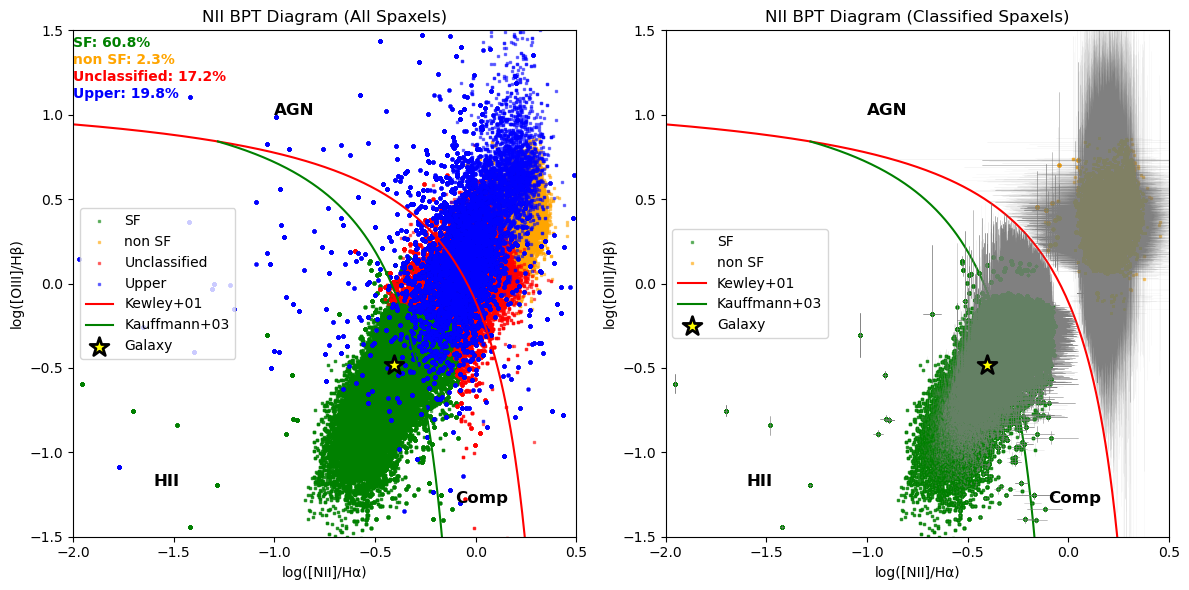

In [13]:
# Calculate flux-weighted representative points for BPT diagrams
# For N2-BPT diagram
if np.sum(mask_classified_N2) > 0:
    galaxy_logO3_N2 = np.log10(np.nansum(OIII5006_FLUX_corr[mask_classified_N2])/np.nansum(HB4861_FLUX_corr[mask_classified_N2]))
    galaxy_logN2 = np.log10(np.nansum(NII6583_FLUX_corr[mask_classified_N2])/np.nansum(HA6562_FLUX_corr[mask_classified_N2]))
else:
    galaxy_logN2 = np.nan
    galaxy_logO3_N2 = np.nan

# plot these 4 final cases on the NII BPT diagrams 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(logN2[mask_SF_N2], logO3[mask_SF_N2], 
            color='green', label='SF', marker=',', s=1, alpha=0.5)
plt.scatter(logN2[mask_nonSF_N2], logO3[mask_nonSF_N2], 
            color='orange', label='non SF', marker=',', s=1, alpha=0.5)
plt.scatter(logN2[mask_unclassified_N2], logO3[mask_unclassified_N2], 
            color='red', label='Unclassified', marker=',', s=1, alpha=0.5)
plt.scatter(logN2[mask_upper], logO3[mask_upper], 
            color='blue', label='Upper', marker=',', s=1, alpha=0.5)
# plt.scatter(logN2[mask_SF_noise_N2], logO3[mask_SF_noise_N2], 
#             color='black', label='SF Noise', marker=',', s=1, alpha=0.5)
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')

# Add flux-weighted representative point
if not np.isnan(galaxy_logN2) and not np.isnan(galaxy_logO3_N2):
    plt.scatter(galaxy_logN2, galaxy_logO3_N2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)

# Calculate percentages
sf_percent = np.sum(mask_SF_N2) / total_spaxels * 100
nonsf_percent = np.sum(mask_nonSF_N2) / total_spaxels * 100
unclassified_percent = np.sum(mask_unclassified_N2) / total_spaxels * 100
upper_percent = np.sum(mask_upper) / total_spaxels * 100

# Add percentage annotations in top left
plt.text(-2.0, 1.4, f'SF: {sf_percent:.1f}%', fontsize=10, color='green', fontweight='bold')
plt.text(-2.0, 1.3, f'non SF: {nonsf_percent:.1f}%', fontsize=10, color='orange', fontweight='bold')
plt.text(-2.0, 1.2, f'Unclassified: {unclassified_percent:.1f}%', fontsize=10, color='red', fontweight='bold')
plt.text(-2.0, 1.1, f'Upper: {upper_percent:.1f}%', fontsize=10, color='blue', fontweight='bold')

plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram (All Spaxels)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')


plt.subplot(1, 2, 2)
plt.scatter(logN2[mask_SF_N2], logO3[mask_SF_N2], 
            color='green', label='SF', marker=',', s=1, alpha=0.5)
plt.scatter(logN2[mask_nonSF_N2], logO3[mask_nonSF_N2], 
            color='orange', label='non SF', marker=',', s=1, alpha=0.5)
# plt.scatter(logN2[mask_SF_noise_N2], logO3[mask_SF_noise_N2], 
#             color='black', label='SF Noise', marker=',', s=1, alpha=0.5)
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')

# Add flux-weighted representative point
if not np.isnan(galaxy_logN2) and not np.isnan(galaxy_logO3_N2):
    plt.scatter(galaxy_logN2, galaxy_logO3_N2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)
    
# Show classified error bars
plt.errorbar(logN2[mask_classified_N2], logO3[mask_classified_N2], 
             xerr=logN2_err[mask_classified_N2], yerr=logO3_err[mask_classified_N2],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)

plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram (Classified Spaxels)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

plt.tight_layout()
plt.show()

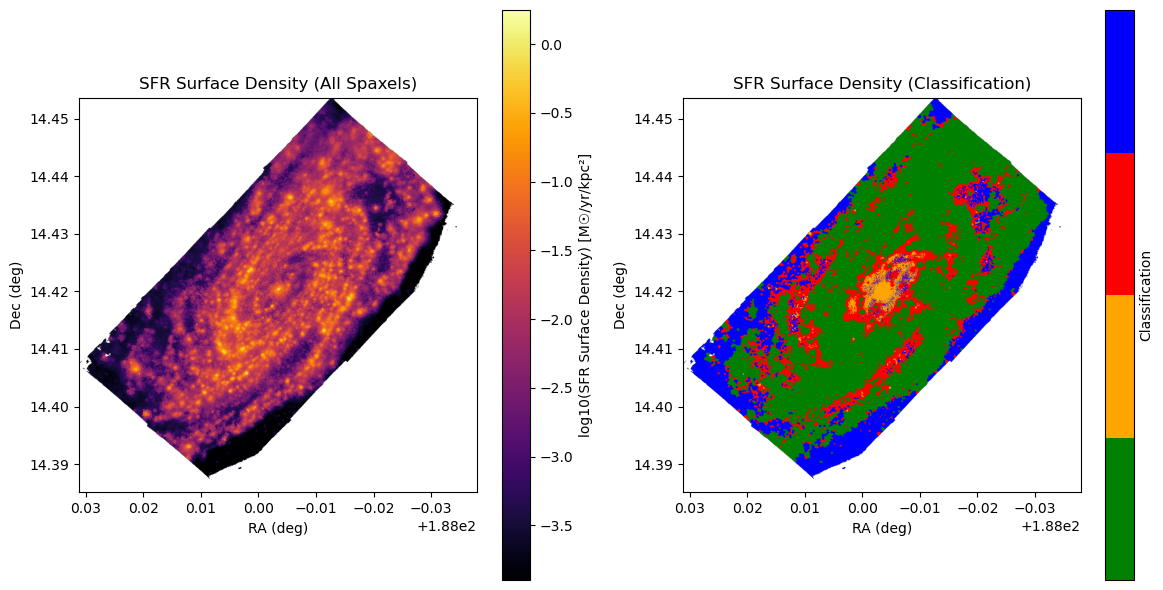

In [14]:
# plot the SFR surface density, left panel show all the spaxels, right panel shows 4 final cases 
plt.figure(figsize=(12, 6))

# Get the extent from WCS for proper coordinate axes
y_size, x_size = LOG_SFR_surface_density_map.shape
x_coords = np.arange(x_size)
y_coords = np.arange(y_size)
xx, yy = np.meshgrid(x_coords, y_coords)
# Convert pixel coordinates to world coordinates
ra, dec = legacy_wcs2.pixel_to_world_values(xx, yy)
extent = [ra.max(), ra.min(), dec.min(), dec.max()]  # [left, right, bottom, top]

plt.subplot(1, 2, 1)
plt.imshow(LOG_SFR_surface_density_map, origin='lower', cmap='inferno', 
           extent=extent)
plt.colorbar(label='log10(SFR Surface Density) [M☉/yr/kpc²]')
plt.title('SFR Surface Density (All Spaxels)')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

plt.subplot(1, 2, 2)
# Create legend patches for the 4 cases
# Create a classification map where each pixel has a value representing its case
classification_map = np.full_like(LOG_SFR_surface_density_map, np.nan)
classification_map[mask_SF_N2 & np.isfinite(LOG_SFR_surface_density_map)] = 1
classification_map[mask_nonSF_N2 & np.isfinite(LOG_SFR_surface_density_map)] = 2
classification_map[mask_unclassified_N2 & np.isfinite(LOG_SFR_surface_density_map)] = 3
classification_map[mask_upper & np.isfinite(LOG_SFR_surface_density_map)] = 4
# classification_map[mask_SF_noise_N2 & np.isfinite(LOG_SFR_surface_density_map)] = 5

# Create a custom colormap for the 4 cases
colors = ['green', 'orange', 'red', 'blue']
cmap_cases = ListedColormap(colors)

plt.imshow(classification_map, origin='lower', cmap=cmap_cases, 
           extent=extent, vmin=0.5, vmax=(len(colors)+0.5))
cbar = plt.colorbar(label='Classification', ticks=[0])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('SFR Surface Density (Classification)')

plt.tight_layout()
plt.show()

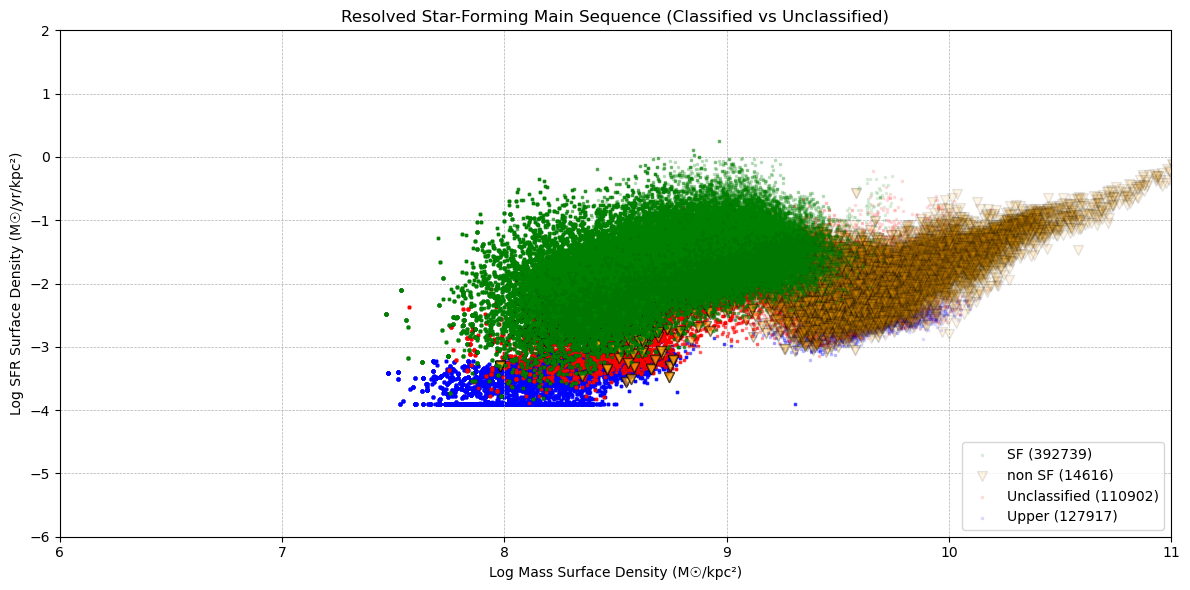

In [15]:
# rSFMS plot with classification
plt.figure(figsize=(12, 6))
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_SF_N2], 
            LOG_SFR_surface_density_map[mask_SF_N2], 
            s=1, marker=',', alpha=0.1, color='green', label=f'SF ({np.sum(mask_SF_N2)})', 
            zorder=3)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_nonSF_N2], 
            LOG_SFR_surface_density_map[mask_nonSF_N2], 
            s=50, marker='v', alpha=0.1, color='orange', edgecolors='black', label=f'non SF ({np.sum(mask_nonSF_N2)})', 
            zorder=2)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_unclassified_N2], 
            LOG_SFR_surface_density_map[mask_unclassified_N2], 
            s=1, marker=',', alpha=0.1, color='red', label=f'Unclassified ({np.sum(mask_unclassified_N2)})', 
            zorder=1)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_upper], 
            LOG_SFR_surface_density_map[mask_upper], 
            s=1, marker=',', alpha=0.1, color='blue', label=f'Upper ({np.sum(mask_upper)})', 
            zorder=0)
# plt.scatter(LOGMASS_SURFACE_DENSITY[mask_SF_noise_N2], 
#             LOG_SFR_surface_density_map[mask_SF_noise_N2], 
#             s=1, marker=',', alpha=0.1, color='black', label=f'SF Noise ({np.sum(mask_SF_noise_N2)})', 
#             zorder=4)
plt.xlabel('Log Mass Surface Density (M☉/kpc²)')
plt.ylabel('Log SFR Surface Density (M☉/yr/kpc²)')     
plt.title('Resolved Star-Forming Main Sequence (Classified vs Unclassified)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(6, 11)
plt.ylim(-6, 2)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

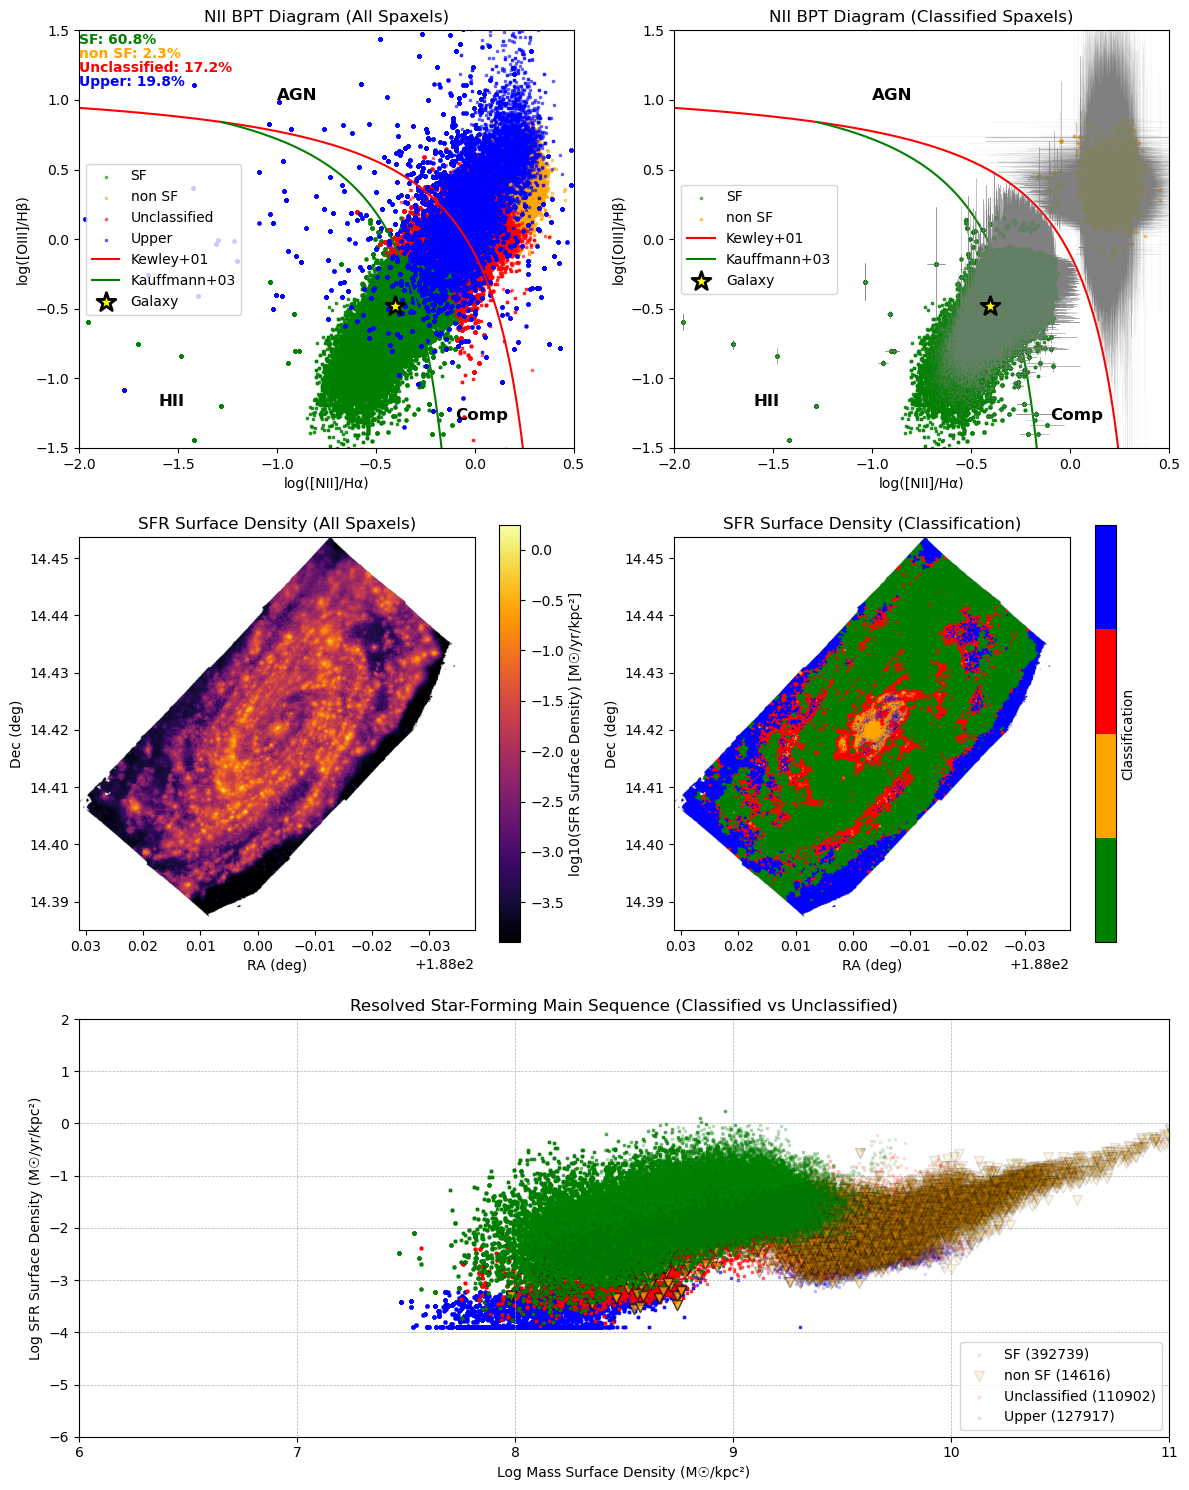

In [16]:
# Calculate flux-weighted representative points for BPT diagrams
# For N2-BPT diagram
if np.sum(mask_classified_N2) > 0:
    galaxy_logO3_N2 = np.log10(np.nansum(OIII5006_FLUX_corr[mask_classified_N2])/np.nansum(HB4861_FLUX_corr[mask_classified_N2]))
    galaxy_logN2 = np.log10(np.nansum(NII6583_FLUX_corr[mask_classified_N2])/np.nansum(HA6562_FLUX_corr[mask_classified_N2]))
else:
    galaxy_logN2 = np.nan
    galaxy_logO3_N2 = np.nan

# plot these 4 final cases on the NII BPT diagrams 
plt.figure(figsize=(12, 15))
plt.subplot(3, 2, 1)
plt.scatter(logN2[mask_SF_N2], logO3[mask_SF_N2], 
            color='green', label='SF', marker=',', s=1, alpha=0.5)
plt.scatter(logN2[mask_nonSF_N2], logO3[mask_nonSF_N2], 
            color='orange', label='non SF', marker=',', s=1, alpha=0.5)
plt.scatter(logN2[mask_unclassified_N2], logO3[mask_unclassified_N2], 
            color='red', label='Unclassified', marker=',', s=1, alpha=0.5)
plt.scatter(logN2[mask_upper], logO3[mask_upper], 
            color='blue', label='Upper', marker=',', s=1, alpha=0.5)
# plt.scatter(logN2[mask_SF_noise_N2], logO3[mask_SF_noise_N2], 
#             color='black', label='SF Noise', marker=',', s=1, alpha=0.5)
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')

# Add flux-weighted representative point
if not np.isnan(galaxy_logN2) and not np.isnan(galaxy_logO3_N2):
    plt.scatter(galaxy_logN2, galaxy_logO3_N2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)

# Calculate percentages
sf_percent = np.sum(mask_SF_N2) / total_spaxels * 100
nonsf_percent = np.sum(mask_nonSF_N2) / total_spaxels * 100
unclassified_percent = np.sum(mask_unclassified_N2) / total_spaxels * 100
upper_percent = np.sum(mask_upper) / total_spaxels * 100

# Add percentage annotations in top left
plt.text(-2.0, 1.4, f'SF: {sf_percent:.1f}%', fontsize=10, color='green', fontweight='bold')
plt.text(-2.0, 1.3, f'non SF: {nonsf_percent:.1f}%', fontsize=10, color='orange', fontweight='bold')
plt.text(-2.0, 1.2, f'Unclassified: {unclassified_percent:.1f}%', fontsize=10, color='red', fontweight='bold')
plt.text(-2.0, 1.1, f'Upper: {upper_percent:.1f}%', fontsize=10, color='blue', fontweight='bold')

plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram (All Spaxels)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')


plt.subplot(3, 2, 2)
plt.scatter(logN2[mask_SF_N2], logO3[mask_SF_N2], 
            color='green', label='SF', marker=',', s=1, alpha=0.5)
plt.scatter(logN2[mask_nonSF_N2], logO3[mask_nonSF_N2], 
            color='orange', label='non SF', marker=',', s=1, alpha=0.5)
# plt.scatter(logN2[mask_SF_noise_N2], logO3[mask_SF_noise_N2], 
#             color='black', label='SF Noise', marker=',', s=1, alpha=0.5)
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')

# Add flux-weighted representative point
if not np.isnan(galaxy_logN2) and not np.isnan(galaxy_logO3_N2):
    plt.scatter(galaxy_logN2, galaxy_logO3_N2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)
    
# Show classified error bars
plt.errorbar(logN2[mask_classified_N2], logO3[mask_classified_N2], 
             xerr=logN2_err[mask_classified_N2], yerr=logO3_err[mask_classified_N2],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)

plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram (Classified Spaxels)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')



# Get the extent from WCS for proper coordinate axes
y_size, x_size = LOG_SFR_surface_density_map.shape
x_coords = np.arange(x_size)
y_coords = np.arange(y_size)
xx, yy = np.meshgrid(x_coords, y_coords)
# Convert pixel coordinates to world coordinates
ra, dec = legacy_wcs2.pixel_to_world_values(xx, yy)
extent = [ra.max(), ra.min(), dec.min(), dec.max()]  # [left, right, bottom, top]

plt.subplot(3, 2, 3)
plt.imshow(LOG_SFR_surface_density_map, origin='lower', cmap='inferno', 
           extent=extent)
plt.colorbar(label='log10(SFR Surface Density) [M☉/yr/kpc²]')
plt.title('SFR Surface Density (All Spaxels)')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

plt.subplot(3, 2, 4)
# Create legend patches for the 4 cases
# Create a classification map where each pixel has a value representing its case
classification_map = np.full_like(LOG_SFR_surface_density_map, np.nan)
classification_map[mask_SF_N2 & np.isfinite(LOG_SFR_surface_density_map)] = 1
classification_map[mask_nonSF_N2 & np.isfinite(LOG_SFR_surface_density_map)] = 2
classification_map[mask_unclassified_N2 & np.isfinite(LOG_SFR_surface_density_map)] = 3
classification_map[mask_upper & np.isfinite(LOG_SFR_surface_density_map)] = 4
# classification_map[mask_SF_noise_N2 & np.isfinite(LOG_SFR_surface_density_map)] = 5

# Create a custom colormap for the 4 cases
colors = ['green', 'orange', 'red', 'blue']
cmap_cases = ListedColormap(colors)

plt.imshow(classification_map, origin='lower', cmap=cmap_cases, 
           extent=extent, vmin=0.5, vmax=(len(colors)+0.5))
cbar = plt.colorbar(label='Classification', ticks=[0])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('SFR Surface Density (Classification)')

# rSFMS plot with classification
plt.subplot(3, 2, (5, 6))
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_SF_N2], 
            LOG_SFR_surface_density_map[mask_SF_N2], 
            s=1, marker=',', alpha=0.1, color='green', label=f'SF ({np.sum(mask_SF_N2)})', 
            zorder=3)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_nonSF_N2], 
            LOG_SFR_surface_density_map[mask_nonSF_N2], 
            s=50, marker='v', alpha=0.1, color='orange', edgecolors='black', label=f'non SF ({np.sum(mask_nonSF_N2)})', 
            zorder=2)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_unclassified_N2], 
            LOG_SFR_surface_density_map[mask_unclassified_N2], 
            s=1, marker=',', alpha=0.1, color='red', label=f'Unclassified ({np.sum(mask_unclassified_N2)})', 
            zorder=1)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_upper], 
            LOG_SFR_surface_density_map[mask_upper], 
            s=1, marker=',', alpha=0.1, color='blue', label=f'Upper ({np.sum(mask_upper)})', 
            zorder=0)
# plt.scatter(LOGMASS_SURFACE_DENSITY[mask_SF_noise_N2], 
#             LOG_SFR_surface_density_map[mask_SF_noise_N2], 
#             s=1, marker=',', alpha=0.1, color='black', label=f'SF Noise ({np.sum(mask_SF_noise_N2)})', 
#             zorder=4)
plt.xlabel('Log Mass Surface Density (M☉/kpc²)')
plt.ylabel('Log SFR Surface Density (M☉/yr/kpc²)')    
plt.title('Resolved Star-Forming Main Sequence (Classified vs Unclassified)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(6, 11)
plt.ylim(-6, 2)
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

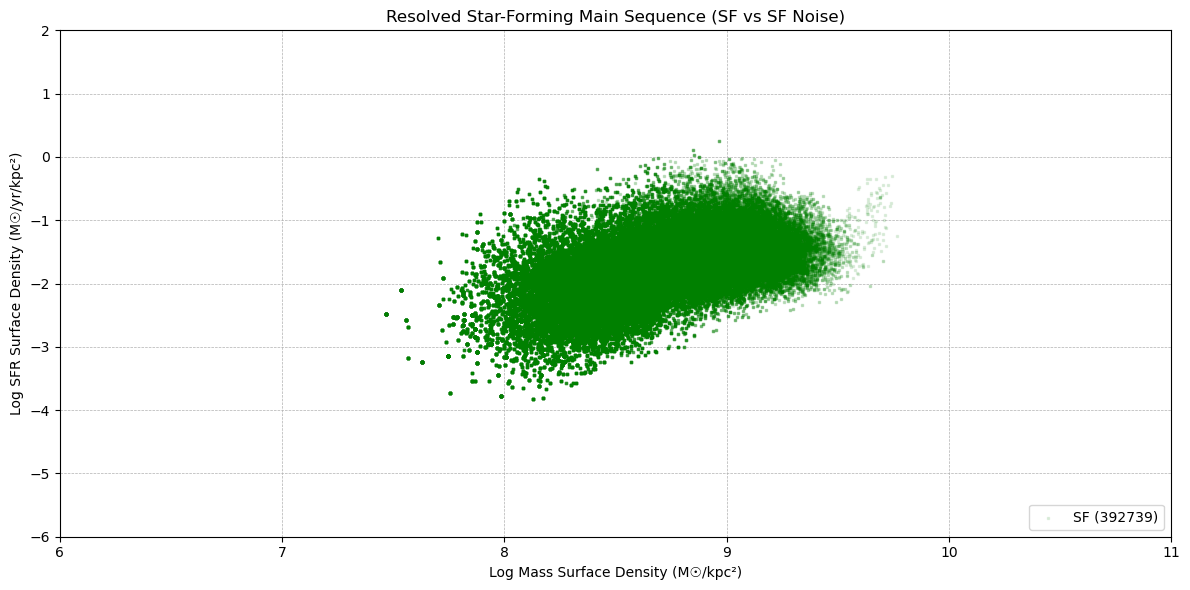

In [17]:
# rSFMS, but green and black points only
plt.figure(figsize=(12, 6))
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_SF_N2], 
            LOG_SFR_surface_density_map[mask_SF_N2], 
            s=1, marker=',', alpha=0.1, color='green', label=f'SF ({np.sum(mask_SF_N2)})', 
            zorder=3)
# plt.scatter(LOGMASS_SURFACE_DENSITY[mask_SF_noise_N2], 
#             LOG_SFR_surface_density_map[mask_SF_noise_N2], 
#             s=1, marker=',', alpha=0.1, color='black', label=f'SF Noise ({np.sum(mask_SF_noise_N2)})', 
#             zorder=4)
plt.xlabel('Log Mass Surface Density (M☉/kpc²)')
plt.ylabel('Log SFR Surface Density (M☉/yr/kpc²)')
plt.title('Resolved Star-Forming Main Sequence (SF vs SF Noise)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(6, 11)
plt.ylim(-6, 2)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## Flags (for [SII] BPT)

Similar to [NII] BPT:
1. Halpha not detected. How to calculate? Use as non-SF in SFR. Need number. 
2. Halpha detected, hbeta not detected. How to calculate? Use as non-SF in SFR. Need number. 
3. Halpha detected, hbeta detected, SII undetected (not both detected), OIII undetected. If unclassified, then need number. If classified (use both SII and OIII as non-SF), then SF go to SFR, while non-SF go to non-SF in SFR. 
4. Halpha detected, hbeta detected, SII undetected (not both detected), OIII detected. If unclassified, then need number. If classified (use SII as non-SF), then SF go to SFR, while non-SF go to non-SF in SFR. 
5. Halpha detected, hbeta detected, SII detected (both detected), OIII undetected. If unclassified, then need number. If unclassified, then need number. If classified (use OIII as non-SF), then SF go to SFR, while non-SF go to non-SF in SFR. 
6. Halpha detected, hbeta detected, SII detected (both detected), OIII detected. If unclassified, then need number. If classified, then SF go to SFR, while non-SF go to non-SF in SFR. 

In [18]:
# # Halpha detected
# HA_detected = HA6562_QC_good
# # Halpha not detected
# HA_not_detected = HA6562_QC_bad

# # Halpha detected, Hbeta detected
# HA_detected_HB_detected = HA6562_QC_good & HB4861_QC_good
# # Halpha detected, Hbeta not detected
# HA_detected_HB_not_detected = HA6562_QC_good & HB4861_QC_bad

# Halpha detected, Hbeta detected, SII detected
HA_detected_HB_detected_SII_detected = HA6562_QC_good & HB4861_QC_good & (SII6716_QC_good & SII6730_QC_good)
# Halpha detected, Hbeta detected, SII not detected
HA_detected_HB_detected_SII_not_detected = HA6562_QC_good & HB4861_QC_good & ~(SII6716_QC_good & SII6730_QC_good)

# Halpha detected, Hbeta detected, SII detected, OIII detected
HA_detected_HB_detected_SII_detected_OIII_detected = (HA6562_QC_good & 
                                                      HB4861_QC_good & 
                                                      (SII6716_QC_good & SII6730_QC_good) &
                                                      OIII5006_QC_good)
# Halpha detected, Hbeta detected, SII detected, OIII not detected
HA_detected_HB_detected_SII_detected_OIII_not_detected = (HA6562_QC_good & 
                                                          HB4861_QC_good & 
                                                          (SII6716_QC_good & SII6730_QC_good) &
                                                          OIII5006_QC_bad)

# Halpha detected, Hbeta detected, SII not detected, OIII detected
HA_detected_HB_detected_SII_not_detected_OIII_detected = (HA6562_QC_good & 
                                                          HB4861_QC_good & 
                                                          ~(SII6716_QC_good & SII6730_QC_good) &
                                                          OIII5006_QC_good)
# Halpha detected, Hbeta detected, SII not detected, OIII not detected
HA_detected_HB_detected_SII_not_detected_OIII_not_detected = (HA6562_QC_good & 
                                                              HB4861_QC_good & 
                                                              ~(SII6716_QC_good & SII6730_QC_good) &
                                                              OIII5006_QC_bad)

In [19]:
# Print the total non-nan spaxels
# total_spaxels = np.sum(np.isfinite(V_STARS2))
print("Total non-nan spaxels:", total_spaxels)
# Print the number of 6 cases that need number, 2 upper cases, and 4 unclassified cases
print("Number of pixels with Halpha not detected:", np.sum(HA_not_detected))
print("Number of pixels with Halpha detected, Hbeta not detected:", np.sum(HA_detected_HB_not_detected))
print("Number of pixels with Halpha detected, Hbeta detected, SII not detected, OIII not detected and unclassified:", 
      np.sum(HA_detected_HB_detected_SII_not_detected_OIII_not_detected & mask_N2_unclassified))
print("Number of pixels with Halpha detected, Hbeta detected, SII not detected, OIII detected and unclassified:",
      np.sum(HA_detected_HB_detected_SII_not_detected_OIII_detected & mask_N2_unclassified))
print("Number of pixels with Halpha detected, Hbeta detected, SII detected, OIII not detected and unclassified:",
      np.sum(HA_detected_HB_detected_SII_detected_OIII_not_detected & mask_N2_unclassified))
print("Number of pixels with Halpha detected, Hbeta detected, SII detected, OIII detected and unclassified:",
      np.sum(HA_detected_HB_detected_SII_detected_OIII_detected & mask_N2_unclassified))

Total non-nan spaxels: 646174
Number of pixels with Halpha not detected: 34557
Number of pixels with Halpha detected, Hbeta not detected: 93360
Number of pixels with Halpha detected, Hbeta detected, SII not detected, OIII not detected and unclassified: 2630
Number of pixels with Halpha detected, Hbeta detected, SII not detected, OIII detected and unclassified: 3609
Number of pixels with Halpha detected, Hbeta detected, SII detected, OIII not detected and unclassified: 8859
Number of pixels with Halpha detected, Hbeta detected, SII detected, OIII detected and unclassified: 95804


In [20]:
# Flag 4 final cases that we want to track for [SII] BPT

# definite SF spaxels: or HA_detected_HB_detected & mask_S2_classified & mask_S2_SF
mask_SF_S2 = ((HA_detected_HB_detected_SII_detected_OIII_detected & mask_S2_classified & mask_S2_SF) | 
              (HA_detected_HB_detected_SII_not_detected_OIII_not_detected & mask_S2_classified & mask_S2_SF) | 
              (HA_detected_HB_detected_SII_not_detected_OIII_detected & mask_S2_classified & mask_S2_SF) | 
              (HA_detected_HB_detected_SII_detected_OIII_not_detected & mask_S2_classified & mask_S2_SF))
# get SFR as non-SF: or HA_detected_HB_detected & mask_S2_classified & mask_S2_nonSF
mask_nonSF_S2 = ((HA_detected_HB_detected_SII_detected_OIII_detected & mask_S2_classified & mask_S2_nonSF) |
                  (HA_detected_HB_detected_SII_not_detected_OIII_not_detected & mask_S2_classified & mask_S2_nonSF) |
                  (HA_detected_HB_detected_SII_not_detected_OIII_detected & mask_S2_classified & mask_S2_nonSF) |
                  (HA_detected_HB_detected_SII_detected_OIII_not_detected & mask_S2_classified & mask_S2_nonSF))
# all the unclassified spaxels: or HA_detected_HB_detected & mask_S2_unclassified
mask_unclassified_S2 = ((HA_detected_HB_detected_SII_not_detected_OIII_not_detected & mask_S2_unclassified) | 
                           (HA_detected_HB_detected_SII_not_detected_OIII_detected & mask_S2_unclassified) | 
                           (HA_detected_HB_detected_SII_detected_OIII_not_detected & mask_S2_unclassified) | 
                           (HA_detected_HB_detected_SII_detected_OIII_detected & mask_S2_unclassified))
# # the rest are upper spaxels: 
# mask_upper = (HA_not_detected | HA_detected_HB_not_detected)
# check if they add up to the total number of spaxels
total_mask_sum_S2 = np.sum(mask_SF_S2) + np.sum(mask_nonSF_S2) + np.sum(mask_unclassified_S2) + np.sum(mask_upper)
if total_mask_sum_S2 == total_spaxels:
    print("The S2 masks add up to the total number of spaxels!")
else:
    print("The S2 masks do not add up to the total number of spaxels!")

# Something else might be useful

# all the constrained spaxels
mask_classified_S2 = mask_SF_S2 | mask_nonSF_S2
# check if they add up to the total number of spaxels
if np.sum(mask_classified_S2) + np.sum(mask_unclassified_S2) + np.sum(mask_upper) == total_spaxels:
    print("The S2 classified, unclassified and upper masks add up to the total number of spaxels!")
else:
    print("The S2 classified, unclassified and upper masks do not add up to the total number of spaxels!")

# all the spaxels that are SF but also noise in either SII or OIII or both, i.e., some noises in mask_SF_S2: 
# or (HA_detected_HB_detected & ~HA_detected_HB_detected_SII_detected_OIII_detected) & mask_S2_classified & mask_S2_SF
mask_SF_noise_S2 = ((HA_detected_HB_detected_SII_not_detected_OIII_not_detected & mask_S2_classified & mask_S2_SF) | 
                     (HA_detected_HB_detected_SII_not_detected_OIII_detected & mask_S2_classified & mask_S2_SF) | 
                     (HA_detected_HB_detected_SII_detected_OIII_not_detected & mask_S2_classified & mask_S2_SF))

The S2 masks add up to the total number of spaxels!
The S2 classified, unclassified and upper masks add up to the total number of spaxels!


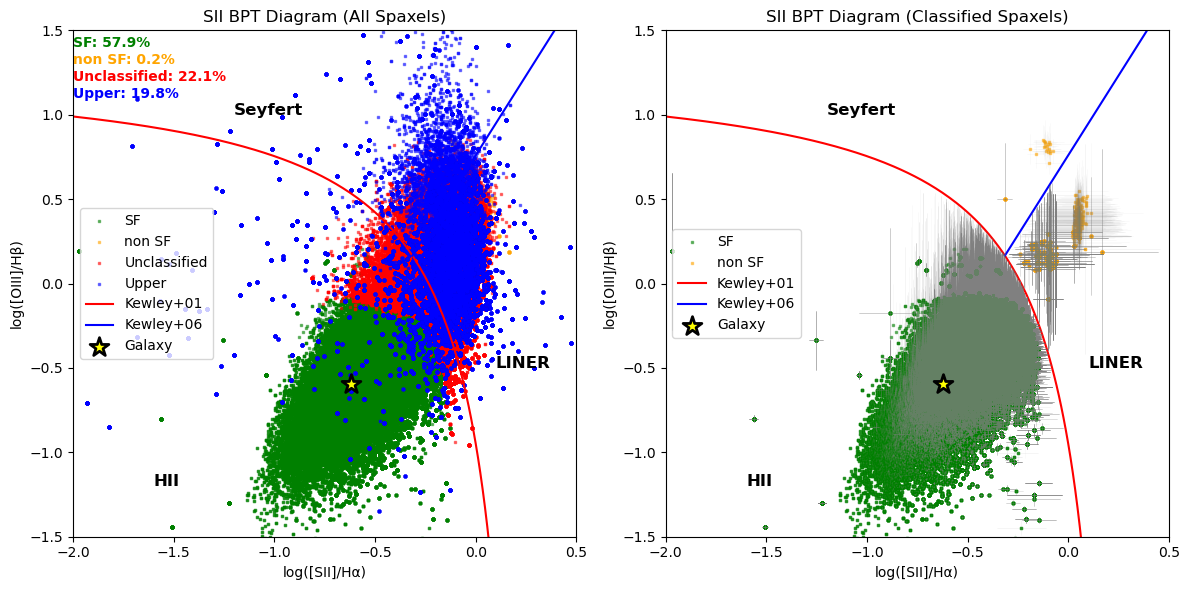

In [21]:
# Calculate flux-weighted representative points for BPT diagrams
# For S2-BPT diagram
if np.sum(mask_classified_S2) > 0:
    galaxy_logO3_S2 = np.log10(np.nansum(OIII5006_FLUX_corr[mask_classified_S2])/np.nansum(HB4861_FLUX_corr[mask_classified_S2]))
    galaxy_logS2 = np.log10(np.nansum((SII6716_FLUX_corr+SII6730_FLUX_corr)[mask_classified_S2])/np.nansum(HA6562_FLUX_corr[mask_classified_S2]))
else:
    galaxy_logS2 = np.nan
    galaxy_logO3_S2 = np.nan

# plot these 4 final cases on the SII BPT diagrams 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(logS2[mask_SF_S2], logO3[mask_SF_S2], 
            color='green', label='SF', marker=',', s=1, alpha=0.5)
plt.scatter(logS2[mask_nonSF_S2], logO3[mask_nonSF_S2], 
            color='orange', label='non SF', marker=',', s=1, alpha=0.5)
plt.scatter(logS2[mask_unclassified_S2], logO3[mask_unclassified_S2], 
            color='red', label='Unclassified', marker=',', s=1, alpha=0.5)
plt.scatter(logS2[mask_upper], logO3[mask_upper], 
            color='blue', label='Upper', marker=',', s=1, alpha=0.5)
# plt.scatter(logS2[mask_SF_noise_S2], logO3[mask_SF_noise_S2], 
#             color='black', label='SF Noise', marker=',', s=1, alpha=0.5)
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')

# Add flux-weighted representative point
if not np.isnan(galaxy_logS2) and not np.isnan(galaxy_logO3_S2):
    plt.scatter(galaxy_logS2, galaxy_logO3_S2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)

# Calculate percentages
sf_percent_S2 = np.sum(mask_SF_S2) / total_spaxels * 100
nonsf_percent_S2 = np.sum(mask_nonSF_S2) / total_spaxels * 100
unclassified_percent_S2 = np.sum(mask_unclassified_S2) / total_spaxels * 100
upper_percent_S2 = np.sum(mask_upper) / total_spaxels * 100

# Add percentage annotations in top left
plt.text(-2.0, 1.4, f'SF: {sf_percent_S2:.1f}%', fontsize=10, color='green', fontweight='bold')
plt.text(-2.0, 1.3, f'non SF: {nonsf_percent_S2:.1f}%', fontsize=10, color='orange', fontweight='bold')
plt.text(-2.0, 1.2, f'Unclassified: {unclassified_percent_S2:.1f}%', fontsize=10, color='red', fontweight='bold')
plt.text(-2.0, 1.1, f'Upper: {upper_percent_S2:.1f}%', fontsize=10, color='blue', fontweight='bold')

plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram (All Spaxels)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

plt.subplot(1, 2, 2)
plt.scatter(logS2[mask_SF_S2], logO3[mask_SF_S2], 
            color='green', label='SF', marker=',', s=1, alpha=0.5)
plt.scatter(logS2[mask_nonSF_S2], logO3[mask_nonSF_S2], 
            color='orange', label='non SF', marker=',', s=1, alpha=0.5)
# plt.scatter(logS2[mask_SF_noise_S2], logO3[mask_SF_noise_S2], 
#             color='black', label='SF Noise', marker=',', s=1, alpha=0.5)
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')

# Add flux-weighted representative point
if not np.isnan(galaxy_logS2) and not np.isnan(galaxy_logO3_S2):
    plt.scatter(galaxy_logS2, galaxy_logO3_S2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)
    
# Show classified error bars
plt.errorbar(logS2[mask_classified_S2], logO3[mask_classified_S2], 
             xerr=logS2_err[mask_classified_S2], yerr=logO3_err[mask_classified_S2],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)

plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram (Classified Spaxels)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

plt.tight_layout()
plt.show()


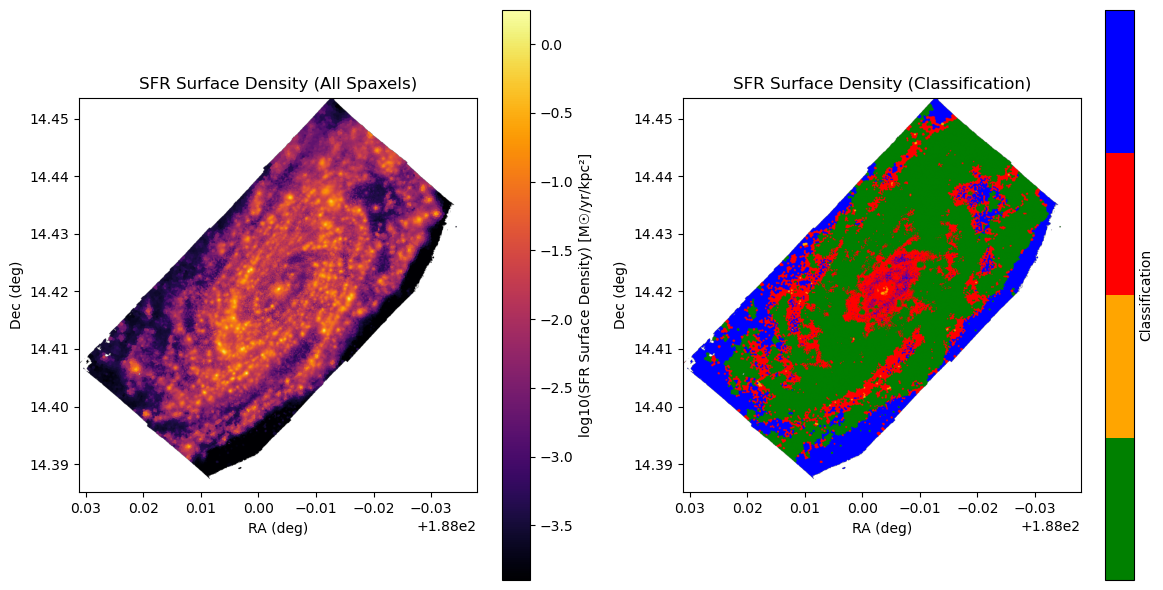

In [22]:
# plot the SFR surface density, left panel show all the spaxels, right panel shows 4 final cases 
plt.figure(figsize=(12, 6))

# Get the extent from WCS for proper coordinate axes
y_size, x_size = LOG_SFR_surface_density_map.shape
x_coords = np.arange(x_size)
y_coords = np.arange(y_size)
xx, yy = np.meshgrid(x_coords, y_coords)
# Convert pixel coordinates to world coordinates
ra, dec = legacy_wcs2.pixel_to_world_values(xx, yy)
extent = [ra.max(), ra.min(), dec.min(), dec.max()]  # [left, right, bottom, top]

plt.subplot(1, 2, 1)
plt.imshow(LOG_SFR_surface_density_map, origin='lower', cmap='inferno', 
           extent=extent)
plt.colorbar(label='log10(SFR Surface Density) [M☉/yr/kpc²]')
plt.title('SFR Surface Density (All Spaxels)')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

plt.subplot(1, 2, 2)
# Create legend patches for the 4 cases
# Create a classification map where each pixel has a value representing its case
classification_map = np.full_like(LOG_SFR_surface_density_map, np.nan)
classification_map[mask_SF_S2 & np.isfinite(LOG_SFR_surface_density_map)] = 1
classification_map[mask_nonSF_S2 & np.isfinite(LOG_SFR_surface_density_map)] = 2
classification_map[mask_unclassified_S2 & np.isfinite(LOG_SFR_surface_density_map)] = 3
classification_map[mask_upper & np.isfinite(LOG_SFR_surface_density_map)] = 4
# classification_map[mask_SF_noise_S2 & np.isfinite(LOG_SFR_surface_density_map)] = 5

# Create a custom colormap for the 4 cases
colors = ['green', 'orange', 'red', 'blue']
cmap_cases = ListedColormap(colors)

plt.imshow(classification_map, origin='lower', cmap=cmap_cases, 
           extent=extent, vmin=0.5, vmax=(len(colors)+0.5))
cbar = plt.colorbar(label='Classification', ticks=[0])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('SFR Surface Density (Classification)')

plt.tight_layout()
plt.show()

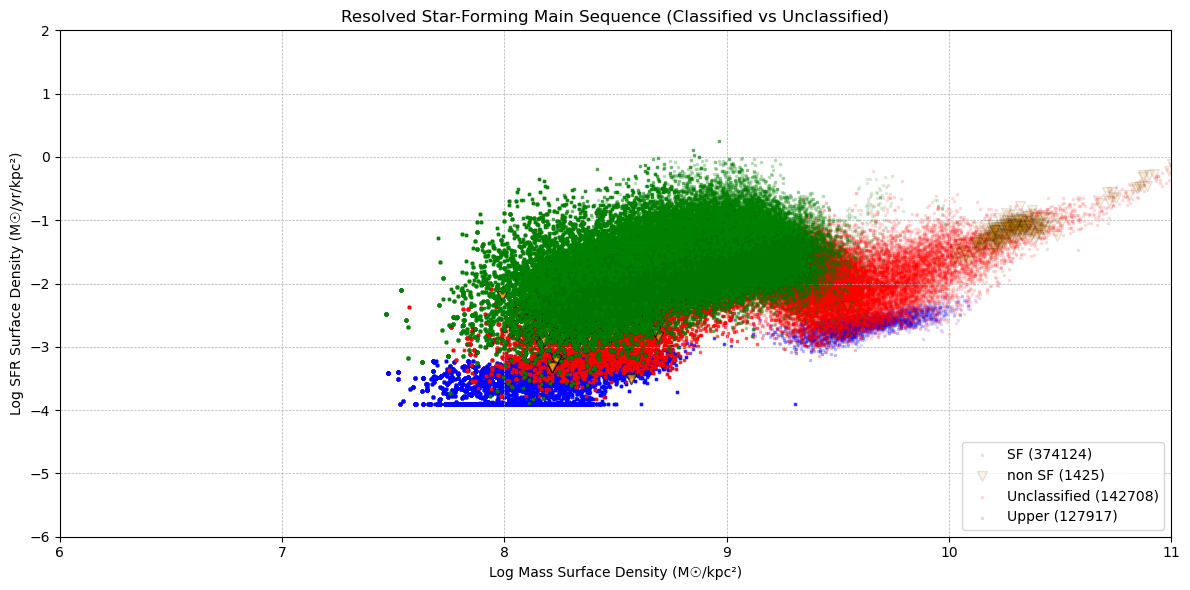

In [23]:
# rSFMS plot with classification for S2 BPT
plt.figure(figsize=(12, 6))
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_SF_S2], 
            LOG_SFR_surface_density_map[mask_SF_S2], 
            s=1, marker=',', alpha=0.1, color='green', label=f'SF ({np.sum(mask_SF_S2)})', 
            zorder=3)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_nonSF_S2], 
            LOG_SFR_surface_density_map[mask_nonSF_S2], 
            s=50, marker='v', alpha=0.1, color='orange', edgecolors='black', label=f'non SF ({np.sum(mask_nonSF_S2)})', 
            zorder=2)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_unclassified_S2], 
            LOG_SFR_surface_density_map[mask_unclassified_S2], 
            s=1, marker=',', alpha=0.1, color='red', label=f'Unclassified ({np.sum(mask_unclassified_S2)})', 
            zorder=1)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_upper], 
            LOG_SFR_surface_density_map[mask_upper], 
            s=1, marker=',', alpha=0.1, color='blue', label=f'Upper ({np.sum(mask_upper)})', 
            zorder=0)
# plt.scatter(LOGMASS_SURFACE_DENSITY[mask_SF_noise_S2], 
#             LOG_SFR_surface_density_map[mask_SF_noise_S2], 
#             s=1, marker=',', alpha=0.1, color='black', label=f'SF Noise ({np.sum(mask_SF_noise_S2)})', 
#             zorder=4)
plt.xlabel('Log Mass Surface Density (M☉/kpc²)')
plt.ylabel('Log SFR Surface Density (M☉/yr/kpc²)')     
plt.title('Resolved Star-Forming Main Sequence (Classified vs Unclassified)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(6, 11)
plt.ylim(-6, 2)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

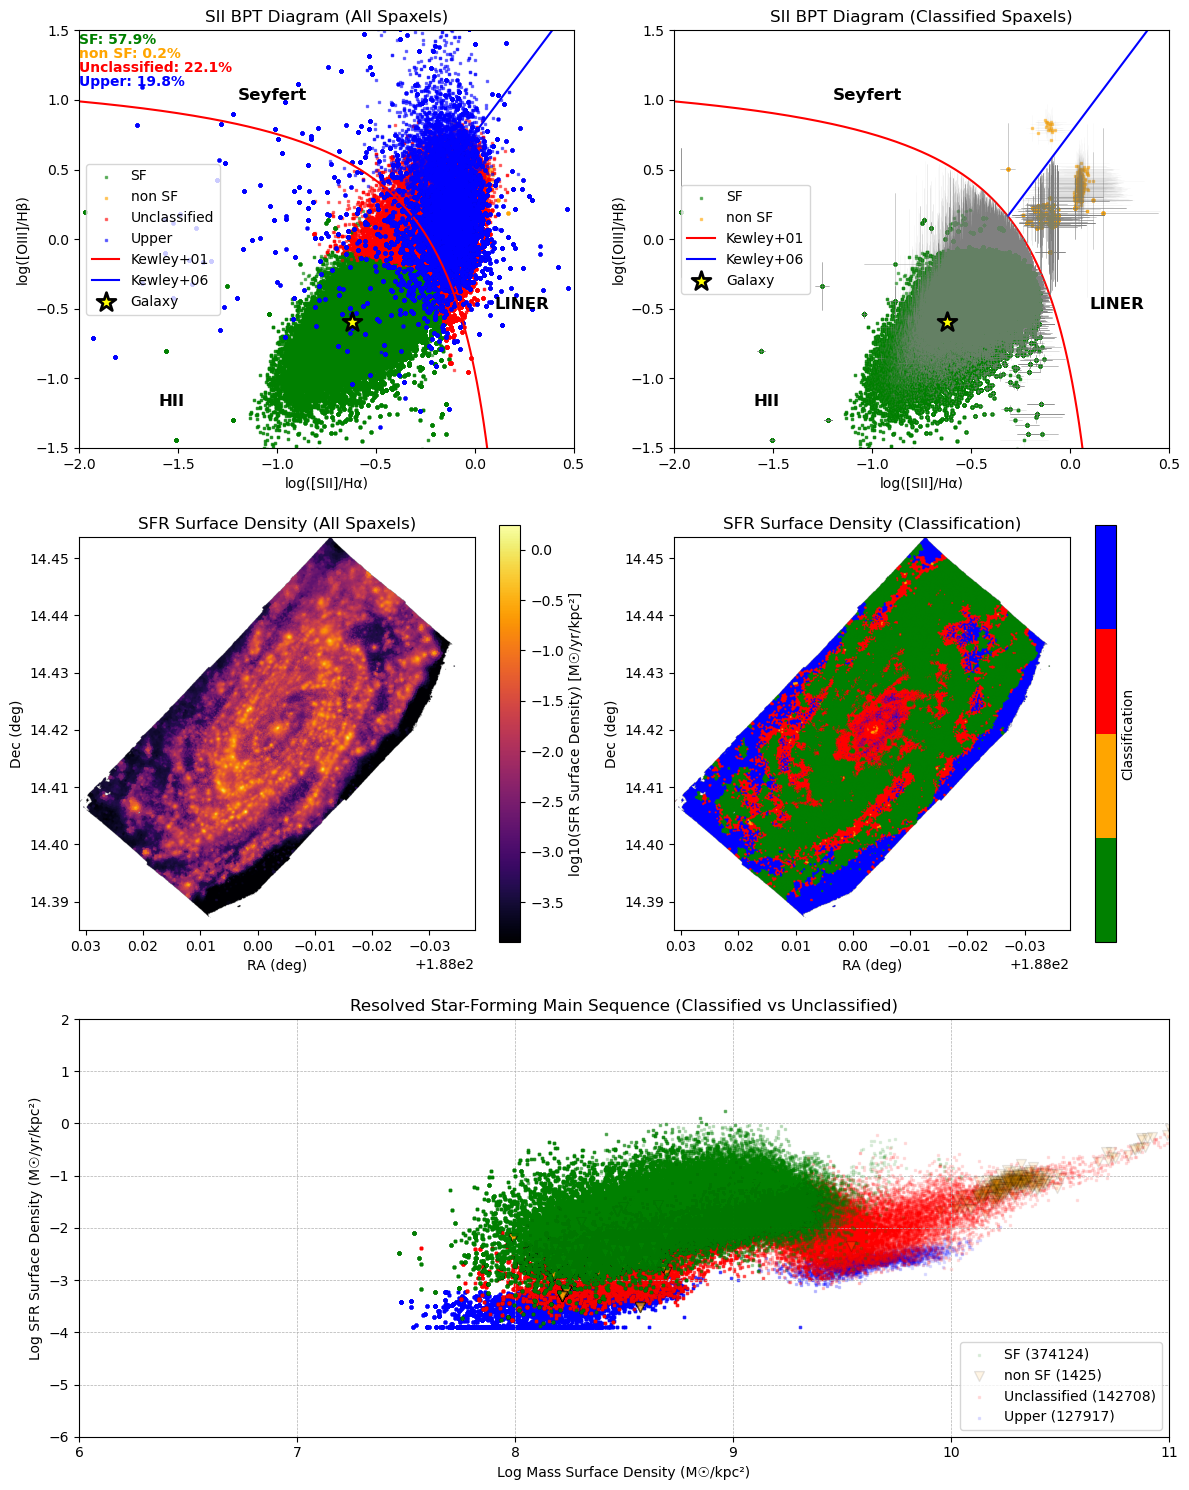

In [24]:
# Calculate flux-weighted representative points for BPT diagrams
# For S2-BPT diagram
if np.sum(mask_classified_S2) > 0:
    galaxy_logO3_S2 = np.log10(np.nansum(OIII5006_FLUX_corr[mask_classified_S2])/np.nansum(HB4861_FLUX_corr[mask_classified_S2]))
    galaxy_logS2 = np.log10(np.nansum(SII6716_FLUX_corr[mask_classified_S2] + SII6730_FLUX_corr[mask_classified_S2])/np.nansum(HA6562_FLUX_corr[mask_classified_S2]))
else:
    galaxy_logS2 = np.nan
    galaxy_logO3_S2 = np.nan

# plot these 4 final cases on the SII BPT diagrams 
plt.figure(figsize=(12, 15))
plt.subplot(3, 2, 1)
plt.scatter(logS2[mask_SF_S2], logO3[mask_SF_S2], 
            color='green', label='SF', marker=',', s=1, alpha=0.5)
plt.scatter(logS2[mask_nonSF_S2], logO3[mask_nonSF_S2], 
            color='orange', label='non SF', marker=',', s=1, alpha=0.5)
plt.scatter(logS2[mask_unclassified_S2], logO3[mask_unclassified_S2], 
            color='red', label='Unclassified', marker=',', s=1, alpha=0.5)
plt.scatter(logS2[mask_upper], logO3[mask_upper], 
            color='blue', label='Upper', marker=',', s=1, alpha=0.5)
# plt.scatter(logS2[mask_SF_noise_S2], logO3[mask_SF_noise_S2], 
#             color='black', label='SF Noise', marker=',', s=1, alpha=0.5)
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')

# Add flux-weighted representative point
if not np.isnan(galaxy_logS2) and not np.isnan(galaxy_logO3_S2):
    plt.scatter(galaxy_logS2, galaxy_logO3_S2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)

# Calculate percentages
sf_percent_S2 = np.sum(mask_SF_S2) / total_spaxels * 100
nonsf_percent_S2 = np.sum(mask_nonSF_S2) / total_spaxels * 100
unclassified_percent_S2 = np.sum(mask_unclassified_S2) / total_spaxels * 100
upper_percent_S2 = np.sum(mask_upper) / total_spaxels * 100

# Add percentage annotations in top left
plt.text(-2.0, 1.4, f'SF: {sf_percent_S2:.1f}%', fontsize=10, color='green', fontweight='bold')
plt.text(-2.0, 1.3, f'non SF: {nonsf_percent_S2:.1f}%', fontsize=10, color='orange', fontweight='bold')
plt.text(-2.0, 1.2, f'Unclassified: {unclassified_percent_S2:.1f}%', fontsize=10, color='red', fontweight='bold')
plt.text(-2.0, 1.1, f'Upper: {upper_percent_S2:.1f}%', fontsize=10, color='blue', fontweight='bold')

plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram (All Spaxels)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')


plt.subplot(3, 2, 2)
plt.scatter(logS2[mask_SF_S2], logO3[mask_SF_S2], 
            color='green', label='SF', marker=',', s=1, alpha=0.5)
plt.scatter(logS2[mask_nonSF_S2], logO3[mask_nonSF_S2], 
            color='orange', label='non SF', marker=',', s=1, alpha=0.5)
# plt.scatter(logS2[mask_SF_noise_S2], logO3[mask_SF_noise_S2], 
#             color='black', label='SF Noise', marker=',', s=1, alpha=0.5)
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')

# Add flux-weighted representative point
if not np.isnan(galaxy_logS2) and not np.isnan(galaxy_logO3_S2):
    plt.scatter(galaxy_logS2, galaxy_logO3_S2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)
    
# Show classified error bars
plt.errorbar(logS2[mask_classified_S2], logO3[mask_classified_S2], 
             xerr=logS2_err[mask_classified_S2], yerr=logO3_err[mask_classified_S2],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)

plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram (Classified Spaxels)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')



# Get the extent from WCS for proper coordinate axes
y_size, x_size = LOG_SFR_surface_density_map.shape
x_coords = np.arange(x_size)
y_coords = np.arange(y_size)
xx, yy = np.meshgrid(x_coords, y_coords)
# Convert pixel coordinates to world coordinates
ra, dec = legacy_wcs2.pixel_to_world_values(xx, yy)
extent = [ra.max(), ra.min(), dec.min(), dec.max()]  # [left, right, bottom, top]

plt.subplot(3, 2, 3)
plt.imshow(LOG_SFR_surface_density_map, origin='lower', cmap='inferno', 
           extent=extent)
plt.colorbar(label='log10(SFR Surface Density) [M☉/yr/kpc²]')
plt.title('SFR Surface Density (All Spaxels)')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

plt.subplot(3, 2, 4)
# Create legend patches for the 4 cases
# Create a classification map where each pixel has a value representing its case
classification_map = np.full_like(LOG_SFR_surface_density_map, np.nan)
classification_map[mask_SF_S2 & np.isfinite(LOG_SFR_surface_density_map)] = 1
classification_map[mask_nonSF_S2 & np.isfinite(LOG_SFR_surface_density_map)] = 2
classification_map[mask_unclassified_S2 & np.isfinite(LOG_SFR_surface_density_map)] = 3
classification_map[mask_upper & np.isfinite(LOG_SFR_surface_density_map)] = 4
# classification_map[mask_SF_noise_S2 & np.isfinite(LOG_SFR_surface_density_map)] = 5

# Create a custom colormap for the 4 cases
colors = ['green', 'orange', 'red', 'blue']
cmap_cases = ListedColormap(colors)

plt.imshow(classification_map, origin='lower', cmap=cmap_cases, 
           extent=extent, vmin=0.5, vmax=(len(colors)+0.5))
cbar = plt.colorbar(label='Classification', ticks=[0])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('SFR Surface Density (Classification)')

# rSFMS plot with classification
plt.subplot(3, 2, (5, 6))
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_SF_S2], 
            LOG_SFR_surface_density_map[mask_SF_S2], 
            s=1, marker=',', alpha=0.1, color='green', label=f'SF ({np.sum(mask_SF_S2)})', 
            zorder=3)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_nonSF_S2], 
            LOG_SFR_surface_density_map[mask_nonSF_S2], 
            s=50, marker='v', alpha=0.1, color='orange', edgecolors='black', label=f'non SF ({np.sum(mask_nonSF_S2)})', 
            zorder=2)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_unclassified_S2], 
            LOG_SFR_surface_density_map[mask_unclassified_S2], 
            s=1, marker=',', alpha=0.1, color='red', label=f'Unclassified ({np.sum(mask_unclassified_S2)})', 
            zorder=1)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_upper], 
            LOG_SFR_surface_density_map[mask_upper], 
            s=1, marker=',', alpha=0.1, color='blue', label=f'Upper ({np.sum(mask_upper)})', 
            zorder=0)
# plt.scatter(LOGMASS_SURFACE_DENSITY[mask_SF_noise_S2], 
#             LOG_SFR_surface_density_map[mask_SF_noise_S2], 
#             s=1, marker=',', alpha=0.1, color='black', label=f'SF Noise ({np.sum(mask_SF_noise_S2)})', 
#             zorder=4)
plt.xlabel('Log Mass Surface Density (M☉/kpc²)')
plt.ylabel('Log SFR Surface Density (M☉/yr/kpc²)')    
plt.title('Resolved Star-Forming Main Sequence (Classified vs Unclassified)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(6, 11)
plt.ylim(-6, 2)
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

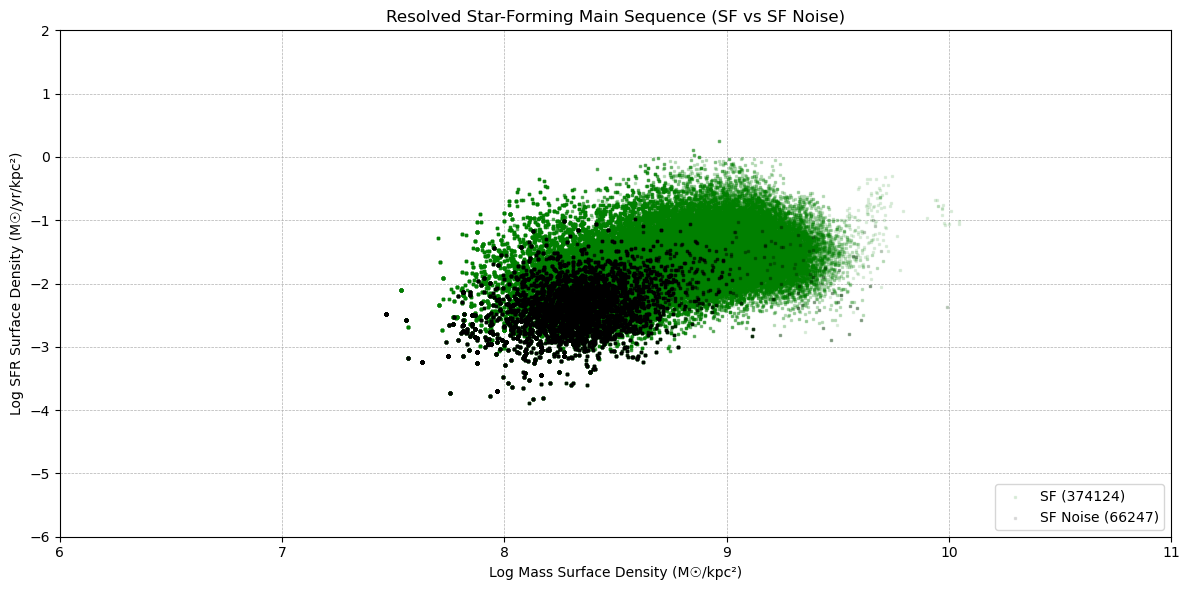

In [25]:
# rSFMS, but green and black points only
plt.figure(figsize=(12, 6))
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_SF_S2], 
            LOG_SFR_surface_density_map[mask_SF_S2], 
            s=1, marker=',', alpha=0.1, color='green', label=f'SF ({np.sum(mask_SF_S2)})', 
            zorder=3)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_SF_noise_S2], 
            LOG_SFR_surface_density_map[mask_SF_noise_S2], 
            s=1, marker=',', alpha=0.1, color='black', label=f'SF Noise ({np.sum(mask_SF_noise_S2)})', 
            zorder=4)
plt.xlabel('Log Mass Surface Density (M☉/kpc²)')
plt.ylabel('Log SFR Surface Density (M☉/yr/kpc²)')
plt.title('Resolved Star-Forming Main Sequence (SF vs SF Noise)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(6, 11)
plt.ylim(-6, 2)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()  


In [26]:
detection_limit = LOG_SFR_surface_density_map<=-4
# print the flux values that below the detection limit
if np.sum(detection_limit) > 0:
    print("Flux values below the detection limit:")
    print("Halpha:", np.nanmax(HA6562_FLUX[detection_limit]))
    print("Hbeta:", np.nanmax(HB4861_FLUX[detection_limit]))
    print("OIII5006:", np.nanmax(OIII5006_FLUX[detection_limit]))
    print("NII6583:", np.nanmax(NII6583_FLUX[detection_limit]))
    print("SII6716:", np.nanmax(SII6716_FLUX[detection_limit]))
    print("SII6730:", np.nanmax(SII6730_FLUX[detection_limit]))
else:
    pass


In [27]:
np.sum(detection_limit)

np.int64(0)

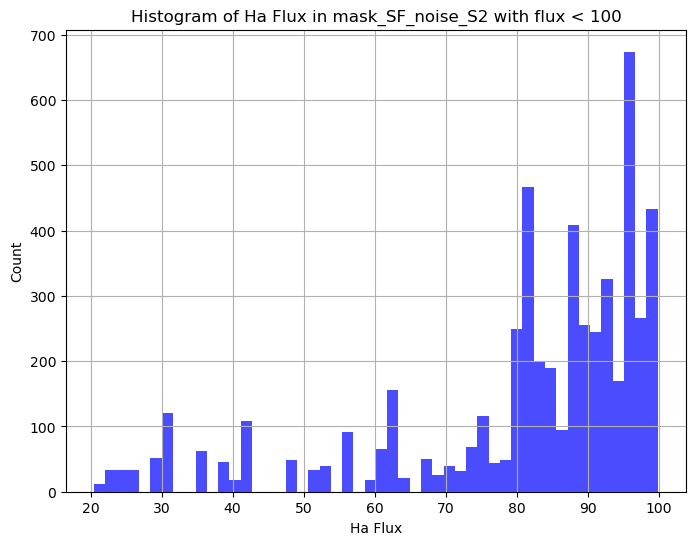

In [28]:
# plot the histogram of Ha flux in mask_SF_noise_S2 with flux < 100
plt.figure(figsize=(8, 6))
plt.hist(HA6562_FLUX[mask_SF_noise_S2*(HA6562_FLUX<100)], bins=50, color='blue', alpha=0.7)
plt.xlabel('Ha Flux')
plt.ylabel('Count')
plt.title('Histogram of Ha Flux in mask_SF_noise_S2 with flux < 100')
plt.grid()
plt.show()

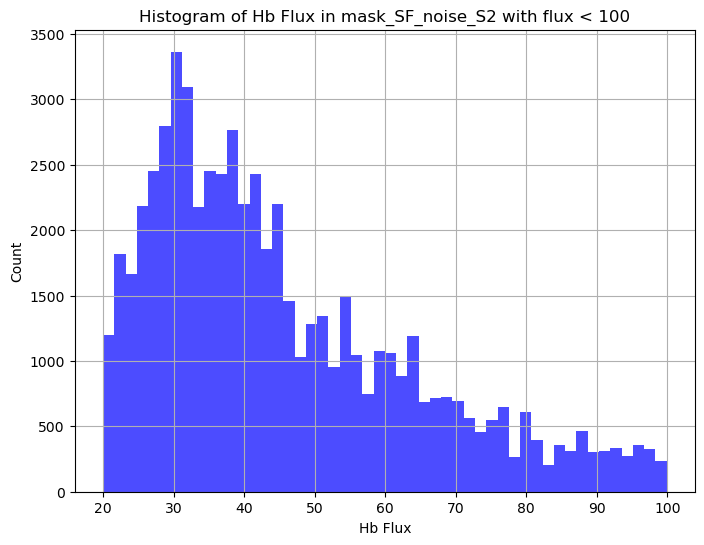

In [29]:
# plot the histogram of Hb flux in mask_SF_noise_S2 with flux < 100
plt.figure(figsize=(8, 6))
plt.hist(HB4861_FLUX[mask_SF_noise_S2*(HB4861_FLUX<100)], bins=50, color='blue', alpha=0.7)
plt.xlabel('Hb Flux')
plt.ylabel('Count')
plt.title('Histogram of Hb Flux in mask_SF_noise_S2 with flux < 100')
plt.grid()
plt.show()

## Combine two BPT

Now we can combine two BPT, so there are two ways: `both` and `either`, to construt 4 final cases. 

### `both`
1. SF: `mask_SF_both = (mask_SF_N2 & mask_SF_S2)`
2. non-SF: `mask_nonSF_both = ((mask_classified_N2 & mask_classified_S2) & ~mask_SF_both)`
3. unclassified: `mask_unclassified_both = ((~(mask_classified_N2 & mask_classified_S2)) & HA_detected_HB_detected)`. Or `mask_unclassified_both = (mask_unclassified_N2 | mask_unclassified_S2)`
4. unknow: this remains the same as mask_upper

### `either`
1. SF: `mask_SF_either = (mask_SF_N2 | mask_SF_S2)`
2. non-SF: `mask_nonSF_either = ((mask_classified_N2 | mask_classified_S2) & ~mask_SF_both)`
3. unclassified: `mask_unclassified_either = ((~(mask_classified_N2 | mask_classified_S2)) & HA_detected_HB_detected)`. Or `mask_unclassified_either = (mask_unclassified_N2 & mask_unclassified_S2)`
4. unknow: this remains the same as mask_upper

In [30]:
# both:

# SF: SF in both N2 and S2 BPT diagrams:
mask_SF_both = mask_SF_N2 & mask_SF_S2
# non SF: constrained in both N2 and S2 BPT diagrams, but not SF in either or both:
mask_nonSF_both = ((mask_classified_N2 & mask_classified_S2) & ~mask_SF_both)
# Unclassified: unclassified in either N2 or S2 BPT diagrams: or 
# mask_unclassified_both = (mask_unclassified_N2 | mask_unclassified_S2)
mask_unclassified_both = ((~(mask_classified_N2 & mask_classified_S2)) & HA_detected_HB_detected)
# Upper: the rest are upper spaxels:
mask_upper = (HA_not_detected | HA_detected_HB_not_detected)
# check if they add up to the total number of spaxels
total_mask_sum_both = np.sum(mask_SF_both) + np.sum(mask_nonSF_both) + np.sum(mask_unclassified_both) + np.sum(mask_upper)
if total_mask_sum_both == total_spaxels:
    print("The masks for both N2 and S2 add up to the total number of spaxels!")
else:
    print("The masks for both N2 and S2 do not add up to the total number of spaxels!")
# Something else might be useful
# all the constrained spaxels: or mask_classified_both = ~mask_unclassified_both
mask_classified_both = (mask_classified_N2 & mask_classified_S2)
# check if they add up to the total number of spaxels
if np.sum(mask_classified_both) + np.sum(mask_unclassified_both) + np.sum(mask_upper) == total_spaxels:
    print("The N2 and S2 classified, unclassified and upper masks add up to the total number of spaxels!")
else:
    print("The N2 and S2 classified, unclassified and upper masks do not add up to the total number of spaxels!")

# either:

# SF: SF in either N2 or S2 BPT diagrams:
mask_SF_either = mask_SF_N2 | mask_SF_S2
# non SF: constrained in either N2 or S2 BPT diagrams, but not SF in either or both:
mask_nonSF_either = ((mask_classified_N2 | mask_classified_S2) & ~mask_SF_either)
# Unclassified: unclassified in either N2 or S2 BPT diagrams: or 
# mask_unclassified_either = (mask_unclassified_N2 & mask_unclassified_S2)
mask_unclassified_either = ((~(mask_classified_N2 | mask_classified_S2)) & HA_detected_HB_detected)
# Upper: the rest are upper spaxels:
mask_upper = (HA_not_detected | HA_detected_HB_not_detected)
# check if they add up to the total number of spaxels
total_mask_sum_either = np.sum(mask_SF_either) + np.sum(mask_nonSF_either) + np.sum(mask_unclassified_either) + np.sum(mask_upper)
if total_mask_sum_either == total_spaxels:
    print("The masks for either N2 or S2 add up to the total number of spaxels!")
else:
    print("The masks for either N2 or S2 do not add up to the total number of spaxels!")
# Something else might be useful
# all the constrained spaxels: or mask_classified_either = ~mask_unclassified_either
mask_classified_either = (mask_classified_N2 | mask_classified_S2)
# check if they add up to the total number of spaxels
if np.sum(mask_classified_either) + np.sum(mask_unclassified_either) + np.sum(mask_upper) == total_spaxels:
    print("The N2 and S2 classified, unclassified and upper masks add up to the total number of spaxels!")
else:
    print("The N2 and S2 classified, unclassified and upper masks do not add up to the total number of spaxels!")

The masks for both N2 and S2 add up to the total number of spaxels!
The N2 and S2 classified, unclassified and upper masks add up to the total number of spaxels!
The masks for either N2 or S2 add up to the total number of spaxels!
The N2 and S2 classified, unclassified and upper masks add up to the total number of spaxels!


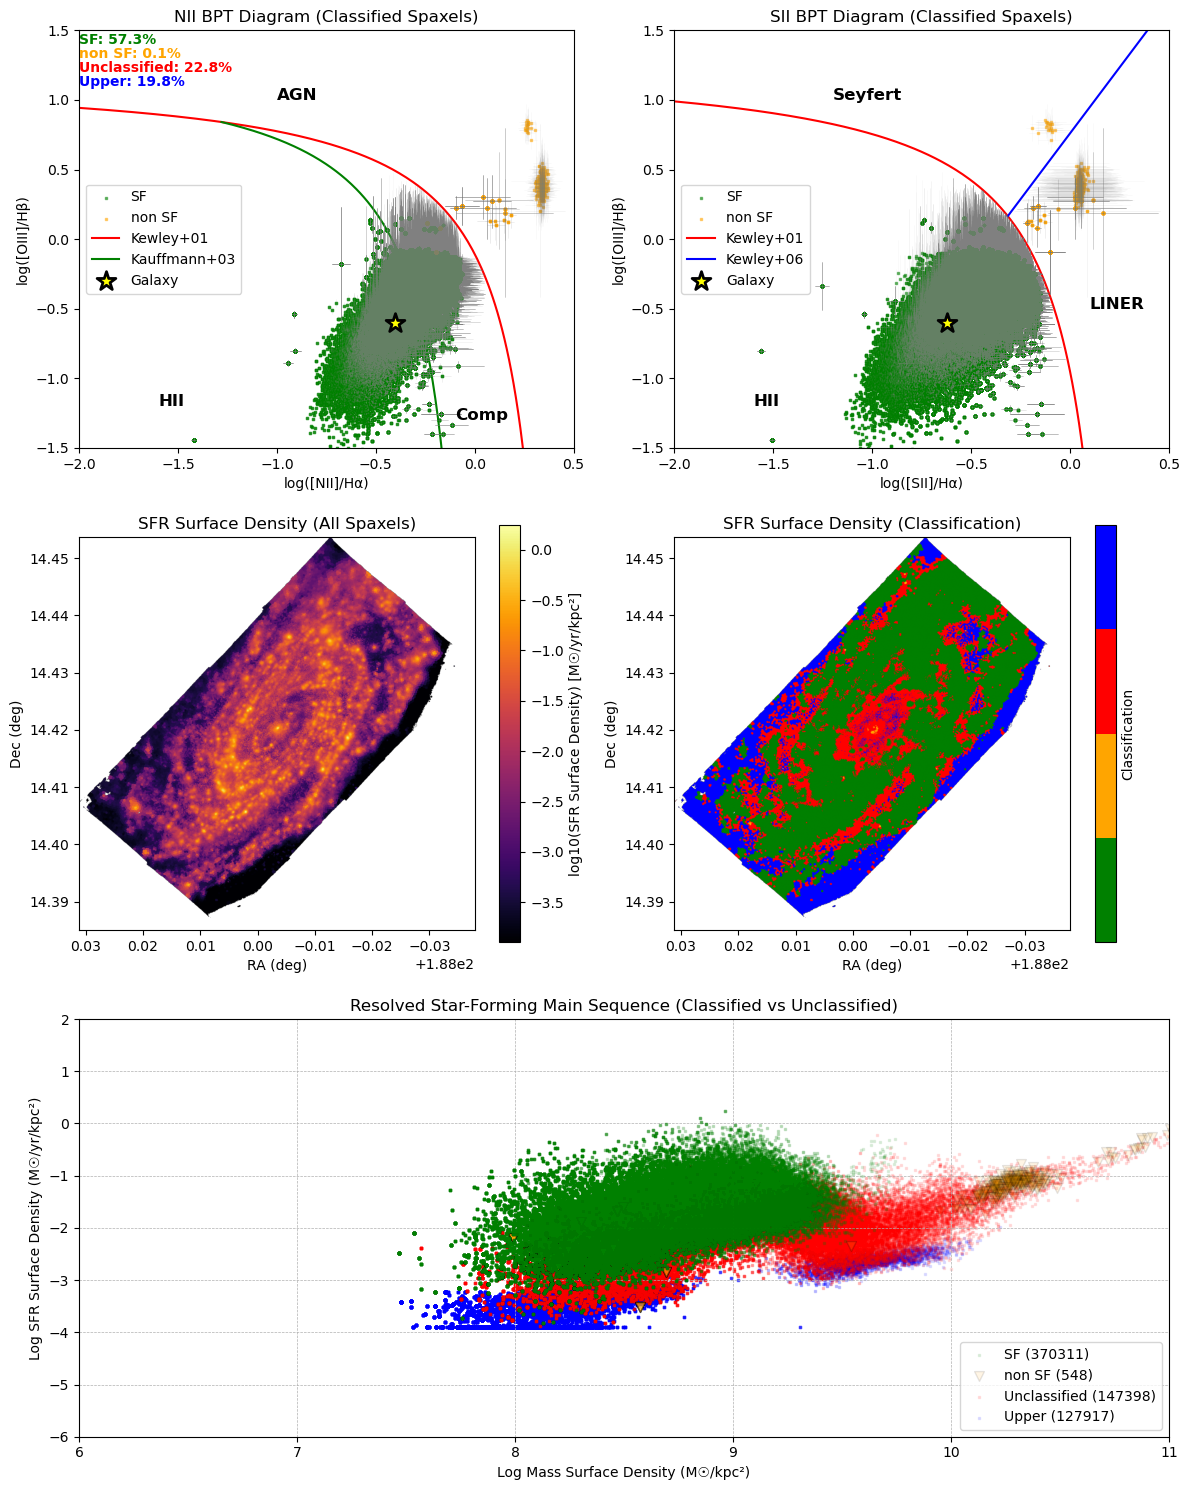

In [31]:
# Calculate flux-weighted representative points for BPT diagrams
# For both BPT diagrams
if np.sum(mask_classified_both) > 0:
    galaxy_logO3_both = np.log10(np.nansum(OIII5006_FLUX_corr[mask_classified_both])/np.nansum(HB4861_FLUX_corr[mask_classified_both]))
    galaxy_logS2 = np.log10(np.nansum(SII6716_FLUX_corr[mask_classified_both] + SII6730_FLUX_corr[mask_classified_both])/np.nansum(HA6562_FLUX_corr[mask_classified_both]))
else:
    galaxy_logS2 = np.nan
    galaxy_logO3_both = np.nan

# plot these 4 final cases on the SII BPT diagrams 
plt.figure(figsize=(12, 15))
plt.subplot(3, 2, 1)
plt.scatter(logN2[mask_SF_both], logO3[mask_SF_both], 
            color='green', label='SF', marker=',', s=1, alpha=0.5)
plt.scatter(logN2[mask_nonSF_both], logO3[mask_nonSF_both], 
            color='orange', label='non SF', marker=',', s=1, alpha=0.5)
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')

# Add flux-weighted representative point
if not np.isnan(galaxy_logN2) and not np.isnan(galaxy_logO3_both):
    plt.scatter(galaxy_logN2, galaxy_logO3_both, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)
    
# Show classified error bars
plt.errorbar(logN2[mask_classified_both], logO3[mask_classified_both], 
             xerr=logN2_err[mask_classified_both], yerr=logO3_err[mask_classified_both],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)

# Calculate percentages
sf_percent_both = np.sum(mask_SF_both) / total_spaxels * 100
nonsf_percent_both = np.sum(mask_nonSF_both) / total_spaxels * 100
unclassified_percent_both = np.sum(mask_unclassified_both) / total_spaxels * 100
upper_percent_both = np.sum(mask_upper) / total_spaxels * 100

# Add percentage annotations in top left
plt.text(-2.0, 1.4, f'SF: {sf_percent_both:.1f}%', fontsize=10, color='green', fontweight='bold')
plt.text(-2.0, 1.3, f'non SF: {nonsf_percent_both:.1f}%', fontsize=10, color='orange', fontweight='bold')
plt.text(-2.0, 1.2, f'Unclassified: {unclassified_percent_both:.1f}%', fontsize=10, color='red', fontweight='bold')
plt.text(-2.0, 1.1, f'Upper: {upper_percent_both:.1f}%', fontsize=10, color='blue', fontweight='bold')

plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram (Classified Spaxels)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')


plt.subplot(3, 2, 2)
plt.scatter(logS2[mask_SF_both], logO3[mask_SF_both], 
            color='green', label='SF', marker=',', s=1, alpha=0.5)
plt.scatter(logS2[mask_nonSF_both], logO3[mask_nonSF_both], 
            color='orange', label='non SF', marker=',', s=1, alpha=0.5)
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')

# Add flux-weighted representative point
if not np.isnan(galaxy_logS2) and not np.isnan(galaxy_logO3_both):
    plt.scatter(galaxy_logS2, galaxy_logO3_both, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)
    
# Show classified error bars
plt.errorbar(logS2[mask_classified_both], logO3[mask_classified_both], 
             xerr=logS2_err[mask_classified_both], yerr=logO3_err[mask_classified_both],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)

plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram (Classified Spaxels)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')



# Get the extent from WCS for proper coordinate axes
y_size, x_size = LOG_SFR_surface_density_map.shape
x_coords = np.arange(x_size)
y_coords = np.arange(y_size)
xx, yy = np.meshgrid(x_coords, y_coords)
# Convert pixel coordinates to world coordinates
ra, dec = legacy_wcs2.pixel_to_world_values(xx, yy)
extent = [ra.max(), ra.min(), dec.min(), dec.max()]  # [left, right, bottom, top]

plt.subplot(3, 2, 3)
plt.imshow(LOG_SFR_surface_density_map, origin='lower', cmap='inferno', 
           extent=extent)
plt.colorbar(label='log10(SFR Surface Density) [M☉/yr/kpc²]')
plt.title('SFR Surface Density (All Spaxels)')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

plt.subplot(3, 2, 4)
# Create legend patches for the 4 cases
# Create a classification map where each pixel has a value representing its case
classification_map = np.full_like(LOG_SFR_surface_density_map, np.nan)
classification_map[mask_SF_both & np.isfinite(LOG_SFR_surface_density_map)] = 1
classification_map[mask_nonSF_both & np.isfinite(LOG_SFR_surface_density_map)] = 2
classification_map[mask_unclassified_both & np.isfinite(LOG_SFR_surface_density_map)] = 3
classification_map[mask_upper & np.isfinite(LOG_SFR_surface_density_map)] = 4
# classification_map[mask_SF_noise_both & np.isfinite(LOG_SFR_surface_density_map)] = 5

# Create a custom colormap for the 4 cases
colors = ['green', 'orange', 'red', 'blue']
cmap_cases = ListedColormap(colors)

plt.imshow(classification_map, origin='lower', cmap=cmap_cases, 
           extent=extent, vmin=0.5, vmax=(len(colors)+0.5))
cbar = plt.colorbar(label='Classification', ticks=[0])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('SFR Surface Density (Classification)')

# rSFMS plot with classification
plt.subplot(3, 2, (5, 6))
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_SF_both], 
            LOG_SFR_surface_density_map[mask_SF_both], 
            s=1, marker=',', alpha=0.1, color='green', label=f'SF ({np.sum(mask_SF_both)})', 
            zorder=3)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_nonSF_both], 
            LOG_SFR_surface_density_map[mask_nonSF_both], 
            s=50, marker='v', alpha=0.1, color='orange', edgecolors='black', label=f'non SF ({np.sum(mask_nonSF_both)})', 
            zorder=2)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_unclassified_both], 
            LOG_SFR_surface_density_map[mask_unclassified_both], 
            s=1, marker=',', alpha=0.1, color='red', label=f'Unclassified ({np.sum(mask_unclassified_both)})', 
            zorder=1)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_upper], 
            LOG_SFR_surface_density_map[mask_upper], 
            s=1, marker=',', alpha=0.1, color='blue', label=f'Upper ({np.sum(mask_upper)})', 
            zorder=0)
plt.xlabel('Log Mass Surface Density (M☉/kpc²)')
plt.ylabel('Log SFR Surface Density (M☉/yr/kpc²)')    
plt.title('Resolved Star-Forming Main Sequence (Classified vs Unclassified)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(6, 11)
plt.ylim(-6, 2)
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

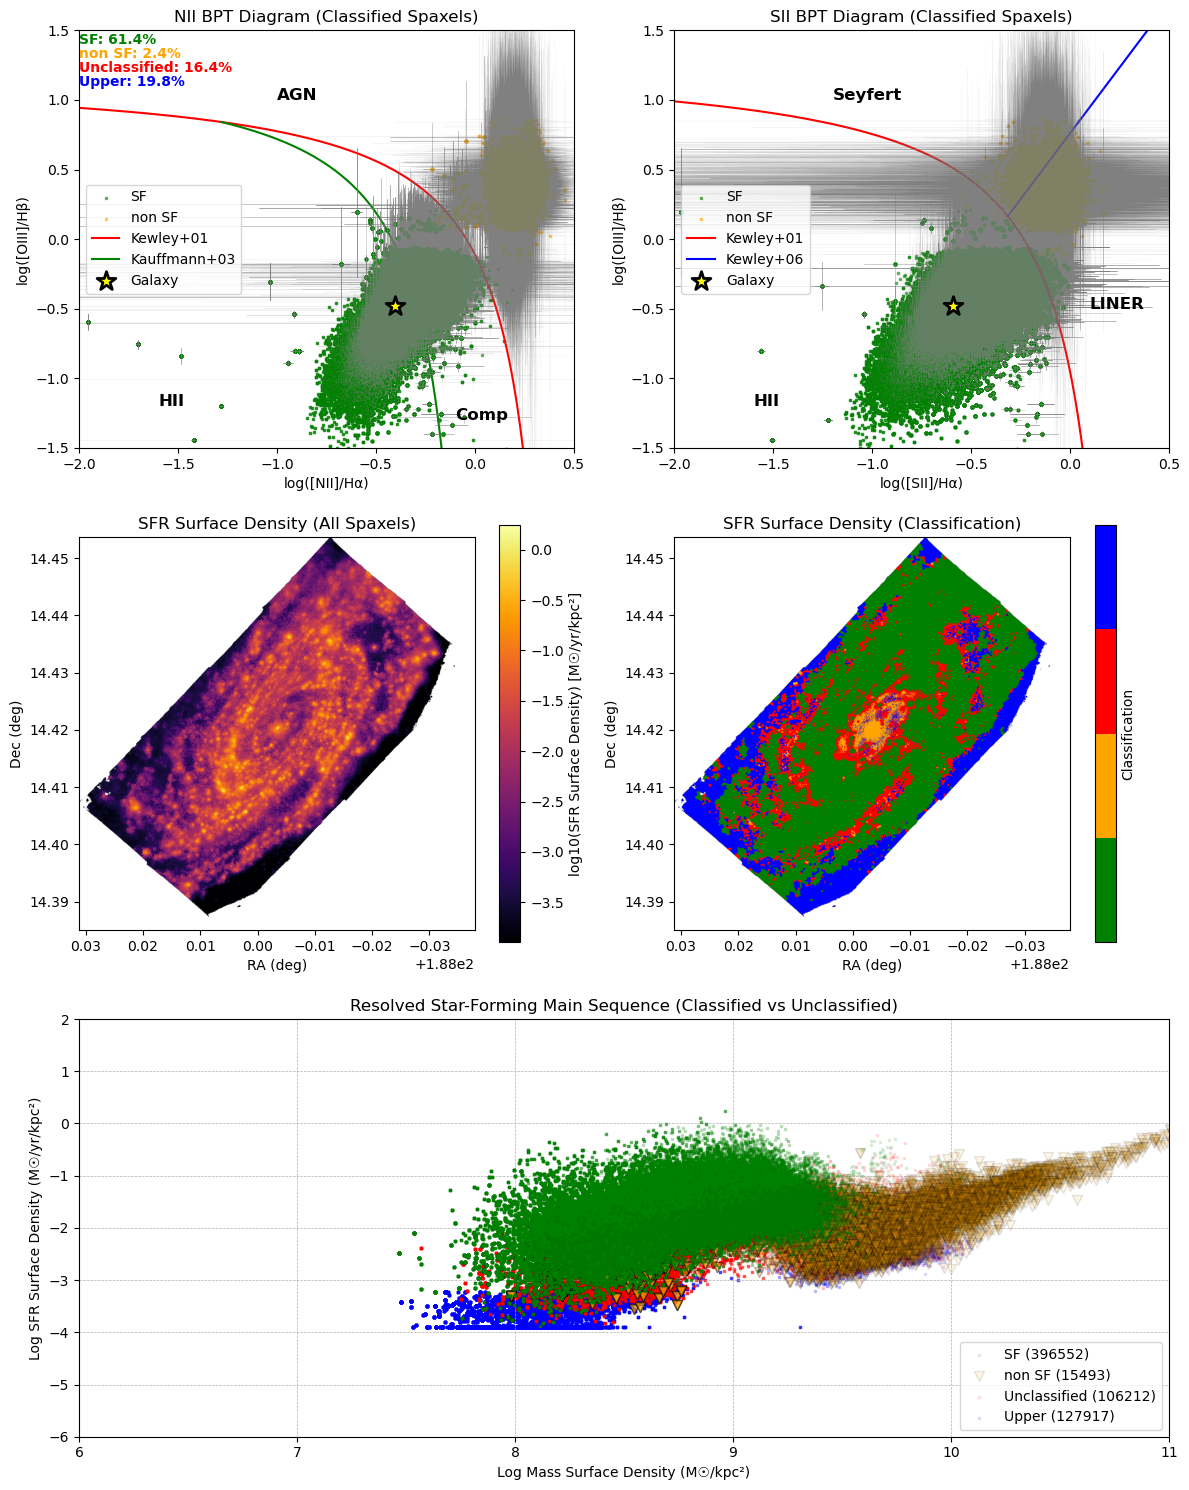

In [32]:
# Calculate flux-weighted representative points for BPT diagrams
# For either BPT diagram (changed from both)
if np.sum(mask_classified_either) > 0:
    galaxy_logO3_either = np.log10(np.nansum(OIII5006_FLUX_corr[mask_classified_either])/np.nansum(HB4861_FLUX_corr[mask_classified_either]))
    galaxy_logS2 = np.log10(np.nansum(SII6716_FLUX_corr[mask_classified_either] + SII6730_FLUX_corr[mask_classified_either])/np.nansum(HA6562_FLUX_corr[mask_classified_either]))
else:
    galaxy_logS2 = np.nan
    galaxy_logO3_either = np.nan

# plot these 4 final cases on the SII BPT diagrams 
plt.figure(figsize=(12, 15))
plt.subplot(3, 2, 1)
plt.scatter(logN2[mask_SF_either], logO3[mask_SF_either], 
            color='green', label='SF', marker=',', s=1, alpha=0.5)
plt.scatter(logN2[mask_nonSF_either], logO3[mask_nonSF_either], 
            color='orange', label='non SF', marker=',', s=1, alpha=0.5)
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')

# Add flux-weighted representative point
if not np.isnan(galaxy_logN2) and not np.isnan(galaxy_logO3_either):
    plt.scatter(galaxy_logN2, galaxy_logO3_either, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)
    
# Show classified error bars
plt.errorbar(logN2[mask_classified_either], logO3[mask_classified_either], 
             xerr=logN2_err[mask_classified_either], yerr=logO3_err[mask_classified_either],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)

# Calculate percentages
sf_percent_either = np.sum(mask_SF_either) / total_spaxels * 100
nonsf_percent_either = np.sum(mask_nonSF_either) / total_spaxels * 100
unclassified_percent_either = np.sum(mask_unclassified_either) / total_spaxels * 100
upper_percent_either = np.sum(mask_upper) / total_spaxels * 100

# Add percentage annotations in top left
plt.text(-2.0, 1.4, f'SF: {sf_percent_either:.1f}%', fontsize=10, color='green', fontweight='bold')
plt.text(-2.0, 1.3, f'non SF: {nonsf_percent_either:.1f}%', fontsize=10, color='orange', fontweight='bold')
plt.text(-2.0, 1.2, f'Unclassified: {unclassified_percent_either:.1f}%', fontsize=10, color='red', fontweight='bold')
plt.text(-2.0, 1.1, f'Upper: {upper_percent_either:.1f}%', fontsize=10, color='blue', fontweight='bold')

plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram (Classified Spaxels)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')


plt.subplot(3, 2, 2)
plt.scatter(logS2[mask_SF_either], logO3[mask_SF_either], 
            color='green', label='SF', marker=',', s=1, alpha=0.5)
plt.scatter(logS2[mask_nonSF_either], logO3[mask_nonSF_either], 
            color='orange', label='non SF', marker=',', s=1, alpha=0.5)
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')

# Add flux-weighted representative point
if not np.isnan(galaxy_logS2) and not np.isnan(galaxy_logO3_either):
    plt.scatter(galaxy_logS2, galaxy_logO3_either, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)
    
# Show classified error bars
plt.errorbar(logS2[mask_classified_either], logO3[mask_classified_either], 
             xerr=logS2_err[mask_classified_either], yerr=logO3_err[mask_classified_either],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)

plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram (Classified Spaxels)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')



# Get the extent from WCS for proper coordinate axes
y_size, x_size = LOG_SFR_surface_density_map.shape
x_coords = np.arange(x_size)
y_coords = np.arange(y_size)
xx, yy = np.meshgrid(x_coords, y_coords)
# Convert pixel coordinates to world coordinates
ra, dec = legacy_wcs2.pixel_to_world_values(xx, yy)
extent = [ra.max(), ra.min(), dec.min(), dec.max()]  # [left, right, bottom, top]

plt.subplot(3, 2, 3)
plt.imshow(LOG_SFR_surface_density_map, origin='lower', cmap='inferno', 
           extent=extent)
plt.colorbar(label='log10(SFR Surface Density) [M☉/yr/kpc²]')
plt.title('SFR Surface Density (All Spaxels)')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

plt.subplot(3, 2, 4)
# Create legend patches for the 4 cases
# Create a classification map where each pixel has a value representing its case
classification_map = np.full_like(LOG_SFR_surface_density_map, np.nan)
classification_map[mask_SF_either & np.isfinite(LOG_SFR_surface_density_map)] = 1
classification_map[mask_nonSF_either & np.isfinite(LOG_SFR_surface_density_map)] = 2
classification_map[mask_unclassified_either & np.isfinite(LOG_SFR_surface_density_map)] = 3
classification_map[mask_upper & np.isfinite(LOG_SFR_surface_density_map)] = 4
# classification_map[mask_SF_noise_either & np.isfinite(LOG_SFR_surface_density_map)] = 5

# Create a custom colormap for the 4 cases
colors = ['green', 'orange', 'red', 'blue']
cmap_cases = ListedColormap(colors)

plt.imshow(classification_map, origin='lower', cmap=cmap_cases, 
           extent=extent, vmin=0.5, vmax=(len(colors)+0.5))
cbar = plt.colorbar(label='Classification', ticks=[0])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('SFR Surface Density (Classification)')

# rSFMS plot with classification
plt.subplot(3, 2, (5, 6))
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_SF_either], 
            LOG_SFR_surface_density_map[mask_SF_either], 
            s=1, marker=',', alpha=0.1, color='green', label=f'SF ({np.sum(mask_SF_either)})', 
            zorder=3)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_nonSF_either], 
            LOG_SFR_surface_density_map[mask_nonSF_either], 
            s=50, marker='v', alpha=0.1, color='orange', edgecolors='black', label=f'non SF ({np.sum(mask_nonSF_either)})', 
            zorder=2)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_unclassified_either], 
            LOG_SFR_surface_density_map[mask_unclassified_either], 
            s=1, marker=',', alpha=0.1, color='red', label=f'Unclassified ({np.sum(mask_unclassified_either)})', 
            zorder=1)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_upper], 
            LOG_SFR_surface_density_map[mask_upper], 
            s=1, marker=',', alpha=0.1, color='blue', label=f'Upper ({np.sum(mask_upper)})', 
            zorder=0)
plt.xlabel('Log Mass Surface Density (M☉/kpc²)')
plt.ylabel('Log SFR Surface Density (M☉/yr/kpc²)')    
plt.title('Resolved Star-Forming Main Sequence (Classified vs Unclassified)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(6, 11)
plt.ylim(-6, 2)
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

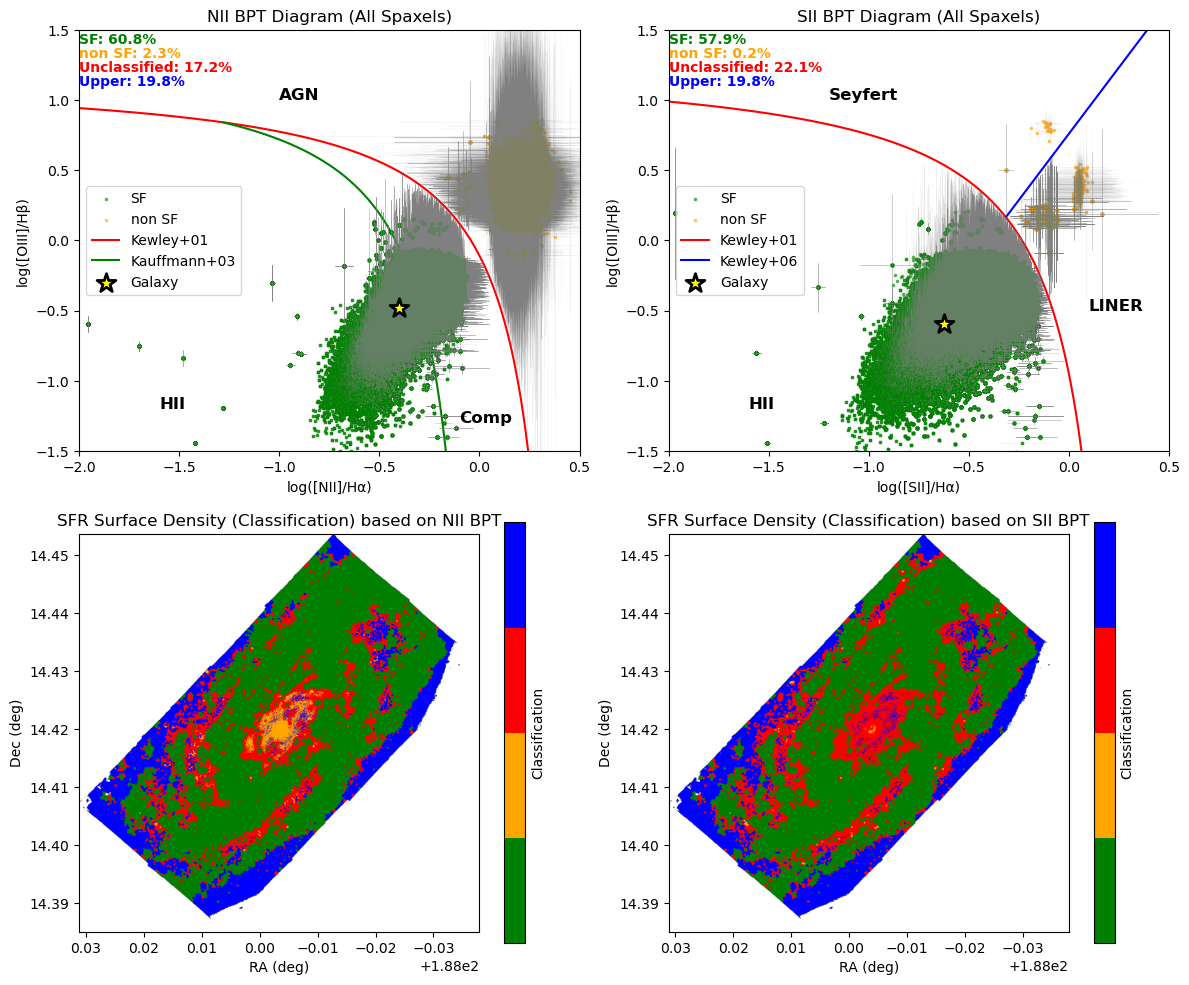

In [33]:
# Calculate flux-weighted representative points for BPT diagrams
# For N2-BPT diagram
if np.sum(mask_classified_N2) > 0:
    galaxy_logO3_N2 = np.log10(np.nansum(OIII5006_FLUX_corr[mask_classified_N2])/np.nansum(HB4861_FLUX_corr[mask_classified_N2]))
    galaxy_logN2 = np.log10(np.nansum(NII6583_FLUX_corr[mask_classified_N2])/np.nansum(HA6562_FLUX_corr[mask_classified_N2]))
else:
    galaxy_logN2 = np.nan
    galaxy_logO3_N2 = np.nan

# For S2-BPT diagram
if np.sum(mask_classified_S2) > 0:
    galaxy_logO3_S2 = np.log10(np.nansum(OIII5006_FLUX_corr[mask_classified_S2])/np.nansum(HB4861_FLUX_corr[mask_classified_S2]))
    galaxy_logS2 = np.log10(np.nansum(SII6716_FLUX_corr[mask_classified_S2] + SII6730_FLUX_corr[mask_classified_S2])/np.nansum(HA6562_FLUX_corr[mask_classified_S2]))
else:
    galaxy_logS2 = np.nan
    galaxy_logO3_S2 = np.nan

# plot these 4 final cases on the NII and SII BPT diagrams as comparison (4 subplots)
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.scatter(logN2[mask_SF_N2], logO3[mask_SF_N2], 
            color='green', label='SF', marker=',', s=1, alpha=0.5)
plt.scatter(logN2[mask_nonSF_N2], logO3[mask_nonSF_N2], 
            color='orange', label='non SF', marker=',', s=1, alpha=0.5)
# plt.scatter(logN2[mask_SF_noise_N2], logO3[mask_SF_noise_N2], 
#             color='black', label='SF Noise', marker=',', s=1, alpha=0.5)
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')
    
# Show classified error bars
plt.errorbar(logN2[mask_classified_N2], logO3[mask_classified_N2], 
             xerr=logN2_err[mask_classified_N2], yerr=logO3_err[mask_classified_N2],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)

# Add flux-weighted representative point
if not np.isnan(galaxy_logN2) and not np.isnan(galaxy_logO3_N2):
    plt.scatter(galaxy_logN2, galaxy_logO3_N2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)

# Calculate percentages
sf_percent = np.sum(mask_SF_N2) / total_spaxels * 100
nonsf_percent = np.sum(mask_nonSF_N2) / total_spaxels * 100
unclassified_percent = np.sum(mask_unclassified_N2) / total_spaxels * 100
upper_percent = np.sum(mask_upper) / total_spaxels * 100

# Add percentage annotations in top left
plt.text(-2.0, 1.4, f'SF: {sf_percent:.1f}%', fontsize=10, color='green', fontweight='bold')
plt.text(-2.0, 1.3, f'non SF: {nonsf_percent:.1f}%', fontsize=10, color='orange', fontweight='bold')
plt.text(-2.0, 1.2, f'Unclassified: {unclassified_percent:.1f}%', fontsize=10, color='red', fontweight='bold')
plt.text(-2.0, 1.1, f'Upper: {upper_percent:.1f}%', fontsize=10, color='blue', fontweight='bold')

plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram (All Spaxels)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

plt.subplot(2, 2, 2)
plt.scatter(logS2[mask_SF_S2], logO3[mask_SF_S2], 
            color='green', label='SF', marker=',', s=1, alpha=0.5)
plt.scatter(logS2[mask_nonSF_S2], logO3[mask_nonSF_S2], 
            color='orange', label='non SF', marker=',', s=1, alpha=0.5)
# plt.scatter(logS2[mask_SF_noise_S2], logO3[mask_SF_noise_S2], 
#             color='black', label='SF Noise', marker=',', s=1, alpha=0.5)
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
    
# Show classified error bars
plt.errorbar(logS2[mask_classified_S2], logO3[mask_classified_S2], 
             xerr=logS2_err[mask_classified_S2], yerr=logO3_err[mask_classified_S2],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)

# Add flux-weighted representative point
if not np.isnan(galaxy_logS2) and not np.isnan(galaxy_logO3_S2):
    plt.scatter(galaxy_logS2, galaxy_logO3_S2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)

# Calculate percentages
sf_percent_S2 = np.sum(mask_SF_S2) / total_spaxels * 100
nonsf_percent_S2 = np.sum(mask_nonSF_S2) / total_spaxels * 100
unclassified_percent_S2 = np.sum(mask_unclassified_S2) / total_spaxels * 100
upper_percent_S2 = np.sum(mask_upper) / total_spaxels * 100

# Add percentage annotations in top left
plt.text(-2.0, 1.4, f'SF: {sf_percent_S2:.1f}%', fontsize=10, color='green', fontweight='bold')
plt.text(-2.0, 1.3, f'non SF: {nonsf_percent_S2:.1f}%', fontsize=10, color='orange', fontweight='bold')
plt.text(-2.0, 1.2, f'Unclassified: {unclassified_percent_S2:.1f}%', fontsize=10, color='red', fontweight='bold')
plt.text(-2.0, 1.1, f'Upper: {upper_percent_S2:.1f}%', fontsize=10, color='blue', fontweight='bold')

plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram (All Spaxels)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

plt.subplot(2, 2, 3)
# Create legend patches for the 4 cases
# Create a classification map where each pixel has a value representing its case
classification_map = np.full_like(LOG_SFR_surface_density_map, np.nan)
classification_map[mask_SF_N2 & np.isfinite(LOG_SFR_surface_density_map)] = 1
classification_map[mask_nonSF_N2 & np.isfinite(LOG_SFR_surface_density_map)] = 2
classification_map[mask_unclassified_N2 & np.isfinite(LOG_SFR_surface_density_map)] = 3
classification_map[mask_upper & np.isfinite(LOG_SFR_surface_density_map)] = 4
# classification_map[mask_SF_noise_N2 & np.isfinite(LOG_SFR_surface_density_map)] = 5

# Create a custom colormap for the 4 cases
colors = ['green', 'orange', 'red', 'blue']
cmap_cases = ListedColormap(colors)

plt.imshow(classification_map, origin='lower', cmap=cmap_cases, 
           extent=extent, vmin=0.5, vmax=(len(colors)+0.5))
cbar = plt.colorbar(label='Classification', ticks=[0])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('SFR Surface Density (Classification) based on NII BPT')

plt.subplot(2, 2, 4)
# Create legend patches for the 4 cases
# Create a classification map where each pixel has a value representing its case
classification_map = np.full_like(LOG_SFR_surface_density_map, np.nan)
classification_map[mask_SF_S2 & np.isfinite(LOG_SFR_surface_density_map)] = 1
classification_map[mask_nonSF_S2 & np.isfinite(LOG_SFR_surface_density_map)] = 2
classification_map[mask_unclassified_S2 & np.isfinite(LOG_SFR_surface_density_map)] = 3
classification_map[mask_upper & np.isfinite(LOG_SFR_surface_density_map)] = 4
# classification_map[mask_SF_noise_S2 & np.isfinite(LOG_SFR_surface_density_map)] = 5

# Create a custom colormap for the 4 cases
colors = ['green', 'orange', 'red', 'blue']
cmap_cases = ListedColormap(colors)

plt.imshow(classification_map, origin='lower', cmap=cmap_cases, 
           extent=extent, vmin=0.5, vmax=(len(colors)+0.5))
cbar = plt.colorbar(label='Classification', ticks=[0])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('SFR Surface Density (Classification) based on SII BPT')

plt.tight_layout()
plt.show()

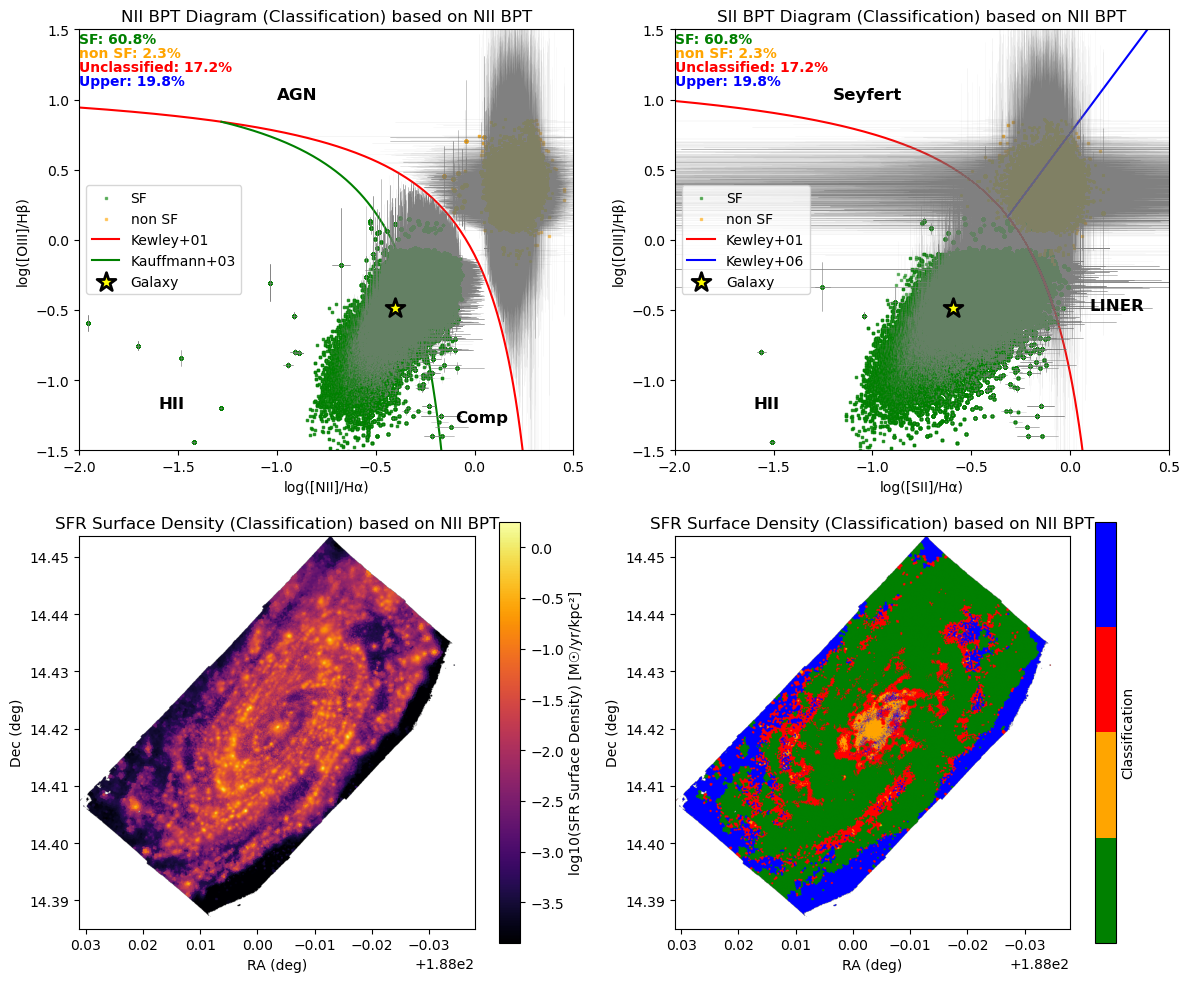

In [34]:
# Calculate flux-weighted representative points for BPT diagrams
# For N2-BPT diagram
if np.sum(mask_classified_N2) > 0:
    galaxy_logO3_N2 = np.log10(np.nansum(OIII5006_FLUX_corr[mask_classified_N2])/np.nansum(HB4861_FLUX_corr[mask_classified_N2]))
    galaxy_logN2 = np.log10(np.nansum(NII6583_FLUX_corr[mask_classified_N2])/np.nansum(HA6562_FLUX_corr[mask_classified_N2]))
else:
    galaxy_logN2 = np.nan
    galaxy_logO3_N2 = np.nan

# For S2-BPT diagram
if np.sum(mask_classified_N2) > 0:
    galaxy_logO3_S2 = np.log10(np.nansum(OIII5006_FLUX_corr[mask_classified_N2])/np.nansum(HB4861_FLUX_corr[mask_classified_N2]))
    galaxy_logS2 = np.log10(np.nansum(SII6716_FLUX_corr[mask_classified_N2] + SII6730_FLUX_corr[mask_classified_N2])/np.nansum(HA6562_FLUX_corr[mask_classified_N2]))
else:
    galaxy_logS2 = np.nan
    galaxy_logO3_S2 = np.nan

# plot these 4 final cases on the NII and SII BPT diagrams as comparison (4 subplots)
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.scatter(logN2[mask_SF_N2], logO3[mask_SF_N2], 
            color='green', label='SF', marker=',', s=1, alpha=0.5)
plt.scatter(logN2[mask_nonSF_N2], logO3[mask_nonSF_N2], 
            color='orange', label='non SF', marker=',', s=1, alpha=0.5)
# plt.scatter(logN2[mask_SF_noise_N2], logO3[mask_SF_noise_N2], 
#             color='black', label='SF Noise', marker=',', s=1, alpha=0.5)
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')
    
# Show classified error bars
plt.errorbar(logN2[mask_classified_N2], logO3[mask_classified_N2], 
             xerr=logN2_err[mask_classified_N2], yerr=logO3_err[mask_classified_N2],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)

# Add flux-weighted representative point
if not np.isnan(galaxy_logN2) and not np.isnan(galaxy_logO3_N2):
    plt.scatter(galaxy_logN2, galaxy_logO3_N2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)

# Calculate percentages
sf_percent = np.sum(mask_SF_N2) / total_spaxels * 100
nonsf_percent = np.sum(mask_nonSF_N2) / total_spaxels * 100
unclassified_percent = np.sum(mask_unclassified_N2) / total_spaxels * 100
upper_percent = np.sum(mask_upper) / total_spaxels * 100

# Add percentage annotations in top left
plt.text(-2.0, 1.4, f'SF: {sf_percent:.1f}%', fontsize=10, color='green', fontweight='bold')
plt.text(-2.0, 1.3, f'non SF: {nonsf_percent:.1f}%', fontsize=10, color='orange', fontweight='bold')
plt.text(-2.0, 1.2, f'Unclassified: {unclassified_percent:.1f}%', fontsize=10, color='red', fontweight='bold')
plt.text(-2.0, 1.1, f'Upper: {upper_percent:.1f}%', fontsize=10, color='blue', fontweight='bold')

plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram (Classification) based on NII BPT')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

plt.subplot(2, 2, 2)
plt.scatter(logS2[mask_SF_N2], logO3[mask_SF_N2], 
            color='green', label='SF', marker=',', s=1, alpha=0.5)
plt.scatter(logS2[mask_nonSF_N2], logO3[mask_nonSF_N2], 
            color='orange', label='non SF', marker=',', s=1, alpha=0.5)
# plt.scatter(logS2[mask_SF_noise_N2], logO3[mask_SF_noise_N2], 
#             color='black', label='SF Noise', marker=',', s=1, alpha=0.5)
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
    
# Show classified error bars
plt.errorbar(logS2[mask_classified_N2], logO3[mask_classified_N2], 
             xerr=logS2_err[mask_classified_N2], yerr=logO3_err[mask_classified_N2],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)

# Add flux-weighted representative point
if not np.isnan(galaxy_logS2) and not np.isnan(galaxy_logO3_S2):
    plt.scatter(galaxy_logS2, galaxy_logO3_S2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)

# Calculate percentages
sf_percent_S2 = np.sum(mask_SF_N2) / total_spaxels * 100
nonsf_percent_S2 = np.sum(mask_nonSF_N2) / total_spaxels * 100
unclassified_percent_S2 = np.sum(mask_unclassified_N2) / total_spaxels * 100
upper_percent_S2 = np.sum(mask_upper) / total_spaxels * 100

# Add percentage annotations in top left
plt.text(-2.0, 1.4, f'SF: {sf_percent_S2:.1f}%', fontsize=10, color='green', fontweight='bold')
plt.text(-2.0, 1.3, f'non SF: {nonsf_percent_S2:.1f}%', fontsize=10, color='orange', fontweight='bold')
plt.text(-2.0, 1.2, f'Unclassified: {unclassified_percent_S2:.1f}%', fontsize=10, color='red', fontweight='bold')
plt.text(-2.0, 1.1, f'Upper: {upper_percent_S2:.1f}%', fontsize=10, color='blue', fontweight='bold')

plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram (Classification) based on NII BPT')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

plt.subplot(2, 2, 3)
plt.imshow(LOG_SFR_surface_density_map, origin='lower', cmap='inferno', 
           extent=extent)
plt.colorbar(label='log10(SFR Surface Density) [M☉/yr/kpc²]')
plt.title('SFR Surface Density (Classification) based on NII BPT')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

plt.subplot(2, 2, 4)
# Create legend patches for the 4 cases
# Create a classification map where each pixel has a value representing its case
classification_map = np.full_like(LOG_SFR_surface_density_map, np.nan)
classification_map[mask_SF_N2 & np.isfinite(LOG_SFR_surface_density_map)] = 1
classification_map[mask_nonSF_N2 & np.isfinite(LOG_SFR_surface_density_map)] = 2
classification_map[mask_unclassified_N2 & np.isfinite(LOG_SFR_surface_density_map)] = 3
classification_map[mask_upper & np.isfinite(LOG_SFR_surface_density_map)] = 4
# classification_map[mask_SF_noise_N2 & np.isfinite(LOG_SFR_surface_density_map)] = 5

# Create a custom colormap for the 4 cases
colors = ['green', 'orange', 'red', 'blue']
cmap_cases = ListedColormap(colors)

plt.imshow(classification_map, origin='lower', cmap=cmap_cases, 
           extent=extent, vmin=0.5, vmax=(len(colors)+0.5))
cbar = plt.colorbar(label='Classification', ticks=[0])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('SFR Surface Density (Classification) based on NII BPT')

plt.tight_layout()
plt.show()

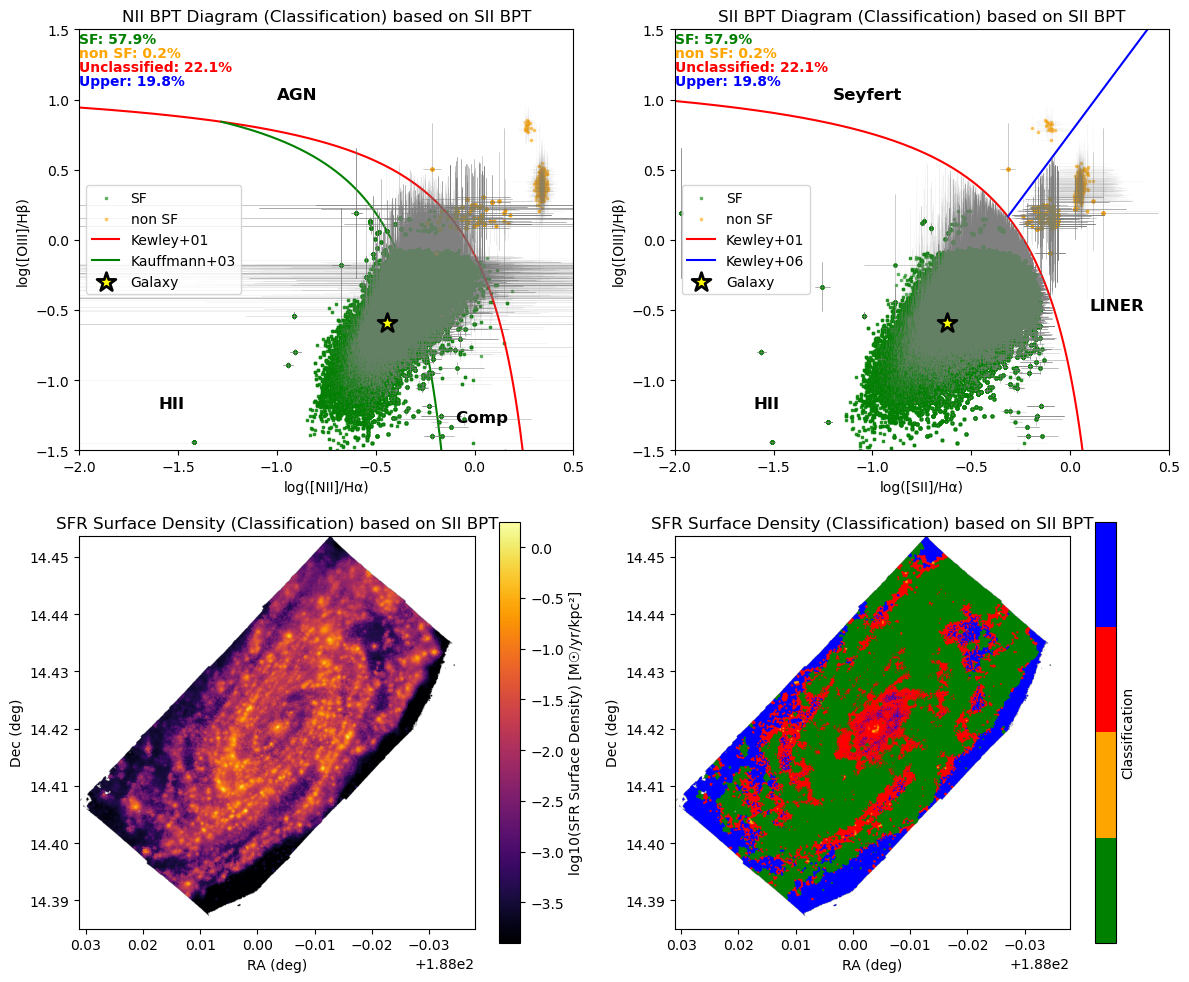

In [35]:
# Calculate flux-weighted representative points for BPT diagrams
# For N2-BPT diagram
if np.sum(mask_classified_S2) > 0:
    galaxy_logO3_N2 = np.log10(np.nansum(OIII5006_FLUX_corr[mask_classified_S2])/np.nansum(HB4861_FLUX_corr[mask_classified_S2]))
    galaxy_logN2 = np.log10(np.nansum(NII6583_FLUX_corr[mask_classified_S2])/np.nansum(HA6562_FLUX_corr[mask_classified_S2]))
else:
    galaxy_logN2 = np.nan
    galaxy_logO3_N2 = np.nan

# For S2-BPT diagram
if np.sum(mask_classified_S2) > 0:
    galaxy_logO3_S2 = np.log10(np.nansum(OIII5006_FLUX_corr[mask_classified_S2])/np.nansum(HB4861_FLUX_corr[mask_classified_S2]))
    galaxy_logS2 = np.log10(np.nansum(SII6716_FLUX_corr[mask_classified_S2] + SII6730_FLUX_corr[mask_classified_S2])/np.nansum(HA6562_FLUX_corr[mask_classified_S2]))
else:
    galaxy_logS2 = np.nan
    galaxy_logO3_S2 = np.nan

# plot these 4 final cases on the NII and SII BPT diagrams as comparison (4 subplots)
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.scatter(logN2[mask_SF_S2], logO3[mask_SF_S2], 
            color='green', label='SF', marker=',', s=1, alpha=0.5)
plt.scatter(logN2[mask_nonSF_S2], logO3[mask_nonSF_S2], 
            color='orange', label='non SF', marker=',', s=1, alpha=0.5)
# plt.scatter(logN2[mask_SF_noise_S2], logO3[mask_SF_noise_S2], 
#             color='black', label='SF Noise', marker=',', s=1, alpha=0.5)
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')
    
# Show classified error bars
plt.errorbar(logN2[mask_classified_S2], logO3[mask_classified_S2], 
             xerr=logN2_err[mask_classified_S2], yerr=logO3_err[mask_classified_S2],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)

# Add flux-weighted representative point
if not np.isnan(galaxy_logN2) and not np.isnan(galaxy_logO3_N2):
    plt.scatter(galaxy_logN2, galaxy_logO3_N2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)

# Calculate percentages
sf_percent = np.sum(mask_SF_S2) / total_spaxels * 100
nonsf_percent = np.sum(mask_nonSF_S2) / total_spaxels * 100
unclassified_percent = np.sum(mask_unclassified_S2) / total_spaxels * 100
upper_percent = np.sum(mask_upper) / total_spaxels * 100

# Add percentage annotations in top left
plt.text(-2.0, 1.4, f'SF: {sf_percent:.1f}%', fontsize=10, color='green', fontweight='bold')
plt.text(-2.0, 1.3, f'non SF: {nonsf_percent:.1f}%', fontsize=10, color='orange', fontweight='bold')
plt.text(-2.0, 1.2, f'Unclassified: {unclassified_percent:.1f}%', fontsize=10, color='red', fontweight='bold')
plt.text(-2.0, 1.1, f'Upper: {upper_percent:.1f}%', fontsize=10, color='blue', fontweight='bold')

plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram (Classification) based on SII BPT')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

plt.subplot(2, 2, 2)
plt.scatter(logS2[mask_SF_S2], logO3[mask_SF_S2], 
            color='green', label='SF', marker=',', s=1, alpha=0.5)
plt.scatter(logS2[mask_nonSF_S2], logO3[mask_nonSF_S2], 
            color='orange', label='non SF', marker=',', s=1, alpha=0.5)
# plt.scatter(logS2[mask_SF_noise_S2], logO3[mask_SF_noise_S2], 
#             color='black', label='SF Noise', marker=',', s=1, alpha=0.5)
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
    
# Show classified error bars
plt.errorbar(logS2[mask_classified_S2], logO3[mask_classified_S2], 
             xerr=logS2_err[mask_classified_S2], yerr=logO3_err[mask_classified_S2],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)

# Add flux-weighted representative point
if not np.isnan(galaxy_logS2) and not np.isnan(galaxy_logO3_S2):
    plt.scatter(galaxy_logS2, galaxy_logO3_S2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)

# Calculate percentages
sf_percent_S2 = np.sum(mask_SF_S2) / total_spaxels * 100
nonsf_percent_S2 = np.sum(mask_nonSF_S2) / total_spaxels * 100
unclassified_percent_S2 = np.sum(mask_unclassified_S2) / total_spaxels * 100
upper_percent_S2 = np.sum(mask_upper) / total_spaxels * 100

# Add percentage annotations in top left
plt.text(-2.0, 1.4, f'SF: {sf_percent_S2:.1f}%', fontsize=10, color='green', fontweight='bold')
plt.text(-2.0, 1.3, f'non SF: {nonsf_percent_S2:.1f}%', fontsize=10, color='orange', fontweight='bold')
plt.text(-2.0, 1.2, f'Unclassified: {unclassified_percent_S2:.1f}%', fontsize=10, color='red', fontweight='bold')
plt.text(-2.0, 1.1, f'Upper: {upper_percent_S2:.1f}%', fontsize=10, color='blue', fontweight='bold')

plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram (Classification) based on SII BPT')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

plt.subplot(2, 2, 3)
plt.imshow(LOG_SFR_surface_density_map, origin='lower', cmap='inferno', 
           extent=extent)
plt.colorbar(label='log10(SFR Surface Density) [M☉/yr/kpc²]')
plt.title('SFR Surface Density (Classification) based on SII BPT')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

plt.subplot(2, 2, 4)
# Create legend patches for the 4 cases
# Create a classification map where each pixel has a value representing its case
classification_map = np.full_like(LOG_SFR_surface_density_map, np.nan)
classification_map[mask_SF_S2 & np.isfinite(LOG_SFR_surface_density_map)] = 1
classification_map[mask_nonSF_S2 & np.isfinite(LOG_SFR_surface_density_map)] = 2
classification_map[mask_unclassified_S2 & np.isfinite(LOG_SFR_surface_density_map)] = 3
classification_map[mask_upper & np.isfinite(LOG_SFR_surface_density_map)] = 4
# classification_map[mask_SF_noise_S2 & np.isfinite(LOG_SFR_surface_density_map)] = 5

# Create a custom colormap for the 4 cases
colors = ['green', 'orange', 'red', 'blue']
cmap_cases = ListedColormap(colors)

plt.imshow(classification_map, origin='lower', cmap=cmap_cases, 
           extent=extent, vmin=0.5, vmax=(len(colors)+0.5))
cbar = plt.colorbar(label='Classification', ticks=[0])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('SFR Surface Density (Classification) based on SII BPT')

plt.tight_layout()
plt.show()

## Inconsistency in NII and SII BPT
Classified on both, but want to see inconsistency on classification across two BPT diagrams. 

In [36]:
# 4 cases under classified in the `both` situation
mask_SF_N2_SF_S2 = mask_classified_both & mask_SF_N2 & mask_SF_S2
mask_nonSF_N2_nonSF_S2 = mask_classified_both & mask_nonSF_N2 & mask_nonSF_S2
mask_nonSF_N2_SF_S2 = mask_classified_both & mask_nonSF_N2 & mask_SF_S2
mask_SF_N2_nonSF_S2 = mask_classified_both & mask_SF_N2 & mask_nonSF_S2
# as usual we have the upper and unclassified cases: mask_upper and mask_unclassified_both

print(f" Total classified spaxels in both: {np.sum(mask_classified_both)}")
print(f" SF in both: {np.sum(mask_SF_N2_SF_S2)}")
print(f" non SF in both: {np.sum(mask_nonSF_N2_nonSF_S2)}")
print(f" non SF in NII, SF in SII: {np.sum(mask_nonSF_N2_SF_S2)}")
print(f" SF in NII, non SF in SII: {np.sum(mask_SF_N2_nonSF_S2)}")

 Total classified spaxels in both: 370859
 SF in both: 370311
 non SF in both: 448
 non SF in NII, SF in SII: 0
 SF in NII, non SF in SII: 100


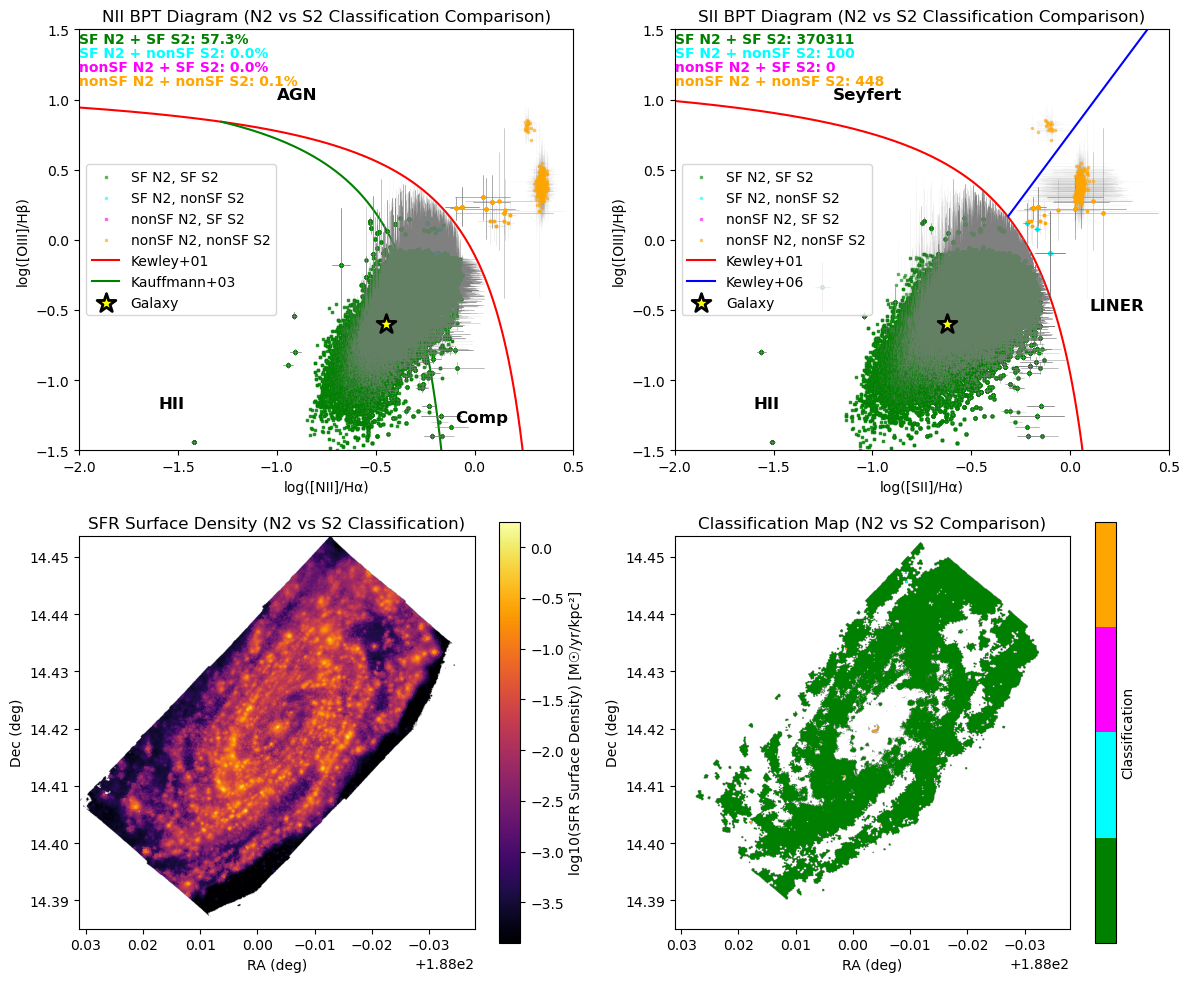

In [37]:
# Calculate flux-weighted representative points for BPT diagrams
# For N2-BPT diagram
if np.sum(mask_classified_both) > 0:
    galaxy_logO3_N2 = np.log10(np.nansum(OIII5006_FLUX_corr[mask_classified_both])/np.nansum(HB4861_FLUX_corr[mask_classified_both]))
    galaxy_logN2 = np.log10(np.nansum(NII6583_FLUX_corr[mask_classified_both])/np.nansum(HA6562_FLUX_corr[mask_classified_both]))
else:
    galaxy_logN2 = np.nan
    galaxy_logO3_N2 = np.nan

# For S2-BPT diagram
if np.sum(mask_classified_both) > 0:
    galaxy_logO3_S2 = np.log10(np.nansum(OIII5006_FLUX_corr[mask_classified_both])/np.nansum(HB4861_FLUX_corr[mask_classified_both]))
    galaxy_logS2 = np.log10(np.nansum(SII6716_FLUX_corr[mask_classified_both] + SII6730_FLUX_corr[mask_classified_both])/np.nansum(HA6562_FLUX_corr[mask_classified_both]))
else:
    galaxy_logS2 = np.nan
    galaxy_logO3_S2 = np.nan

# plot these 4 final cases on the NII and SII BPT diagrams as comparison (4 subplots)
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.scatter(logN2[mask_SF_N2_SF_S2], logO3[mask_SF_N2_SF_S2], 
            color='green', label='SF N2, SF S2', marker=',', s=1, alpha=0.5, zorder=1)
plt.scatter(logN2[mask_SF_N2_nonSF_S2], logO3[mask_SF_N2_nonSF_S2], 
            color='cyan', label='SF N2, nonSF S2', marker=',', s=1, alpha=0.5, zorder=2)
plt.scatter(logN2[mask_nonSF_N2_SF_S2], logO3[mask_nonSF_N2_SF_S2], 
            color='magenta', label='nonSF N2, SF S2', marker=',', s=1, alpha=0.5, zorder=3)
plt.scatter(logN2[mask_nonSF_N2_nonSF_S2], logO3[mask_nonSF_N2_nonSF_S2], 
            color='orange', label='nonSF N2, nonSF S2', marker=',', s=1, alpha=0.5, zorder=4)
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')
    
# Show classified error bars
plt.errorbar(logN2[mask_classified_both], logO3[mask_classified_both], 
             xerr=logN2_err[mask_classified_both], yerr=logO3_err[mask_classified_both],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)

# Add flux-weighted representative point
if not np.isnan(galaxy_logN2) and not np.isnan(galaxy_logO3_N2):
    plt.scatter(galaxy_logN2, galaxy_logO3_N2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)

# Calculate percentages
sf_n2_sf_s2_percent = np.sum(mask_SF_N2_SF_S2) / total_spaxels * 100
sf_n2_nonsf_s2_percent = np.sum(mask_SF_N2_nonSF_S2) / total_spaxels * 100
nonsf_n2_sf_s2_percent = np.sum(mask_nonSF_N2_SF_S2) / total_spaxels * 100
nonsf_n2_nonsf_s2_percent = np.sum(mask_nonSF_N2_nonSF_S2) / total_spaxels * 100

# Add percentage annotations in top left
plt.text(-2.0, 1.4, f'SF N2 + SF S2: {sf_n2_sf_s2_percent:.1f}%', fontsize=10, color='green', fontweight='bold')
plt.text(-2.0, 1.3, f'SF N2 + nonSF S2: {sf_n2_nonsf_s2_percent:.1f}%', fontsize=10, color='cyan', fontweight='bold')
plt.text(-2.0, 1.2, f'nonSF N2 + SF S2: {nonsf_n2_sf_s2_percent:.1f}%', fontsize=10, color='magenta', fontweight='bold')
plt.text(-2.0, 1.1, f'nonSF N2 + nonSF S2: {nonsf_n2_nonsf_s2_percent:.1f}%', fontsize=10, color='orange', fontweight='bold')

plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram (N2 vs S2 Classification Comparison)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

plt.subplot(2, 2, 2)
plt.scatter(logS2[mask_SF_N2_SF_S2], logO3[mask_SF_N2_SF_S2], 
            color='green', label='SF N2, SF S2', marker=',', s=1, alpha=0.5, zorder=1)
plt.scatter(logS2[mask_SF_N2_nonSF_S2], logO3[mask_SF_N2_nonSF_S2], 
            color='cyan', label='SF N2, nonSF S2', marker=',', s=1, alpha=0.5, zorder=2)
plt.scatter(logS2[mask_nonSF_N2_SF_S2], logO3[mask_nonSF_N2_SF_S2], 
            color='magenta', label='nonSF N2, SF S2', marker=',', s=1, alpha=0.5, zorder=3)
plt.scatter(logS2[mask_nonSF_N2_nonSF_S2], logO3[mask_nonSF_N2_nonSF_S2], 
            color='orange', label='nonSF N2, nonSF S2', marker=',', s=1, alpha=0.5, zorder=4)
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
    
# Show classified error bars
plt.errorbar(logS2[mask_classified_both], logO3[mask_classified_both], 
             xerr=logS2_err[mask_classified_both], yerr=logO3_err[mask_classified_both],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)

# Add flux-weighted representative point
if not np.isnan(galaxy_logS2) and not np.isnan(galaxy_logO3_S2):
    plt.scatter(galaxy_logS2, galaxy_logO3_S2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)

# Add percentage annotations in top left
plt.text(-2.0, 1.4, f'SF N2 + SF S2: {np.sum(mask_SF_N2_SF_S2):.0f}', fontsize=10, color='green', fontweight='bold')
plt.text(-2.0, 1.3, f'SF N2 + nonSF S2: {np.sum(mask_SF_N2_nonSF_S2):.0f}', fontsize=10, color='cyan', fontweight='bold')
plt.text(-2.0, 1.2, f'nonSF N2 + SF S2: {np.sum(mask_nonSF_N2_SF_S2):.0f}', fontsize=10, color='magenta', fontweight='bold')
plt.text(-2.0, 1.1, f'nonSF N2 + nonSF S2: {np.sum(mask_nonSF_N2_nonSF_S2):.0f}', fontsize=10, color='orange', fontweight='bold')

plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram (N2 vs S2 Classification Comparison)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

plt.subplot(2, 2, 3)
plt.imshow(LOG_SFR_surface_density_map, origin='lower', cmap='inferno', 
           extent=extent)
plt.colorbar(label='log10(SFR Surface Density) [M☉/yr/kpc²]')
plt.title('SFR Surface Density (N2 vs S2 Classification)')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

plt.subplot(2, 2, 4)
# Create a classification map where each pixel has a value representing its case
classification_map = np.full_like(LOG_SFR_surface_density_map, np.nan)
classification_map[mask_SF_N2_SF_S2 & np.isfinite(LOG_SFR_surface_density_map)] = 1
classification_map[mask_SF_N2_nonSF_S2 & np.isfinite(LOG_SFR_surface_density_map)] = 2
classification_map[mask_nonSF_N2_SF_S2 & np.isfinite(LOG_SFR_surface_density_map)] = 3
classification_map[mask_nonSF_N2_nonSF_S2 & np.isfinite(LOG_SFR_surface_density_map)] = 4

# Create a custom colormap for the 4 cases
colors = ['green', 'cyan', 'magenta', 'orange']
cmap_cases = ListedColormap(colors)

plt.imshow(classification_map, origin='lower', cmap=cmap_cases, 
           extent=extent, vmin=0.5, vmax=(len(colors)+0.5))
cbar = plt.colorbar(label='Classification', ticks=[0])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('Classification Map (N2 vs S2 Comparison)')

plt.tight_layout()
plt.show()
